In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hasanmoni","key":"9bf0c863cb37dea547dcfe75cc650d90"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

##### I Completed this project on Google Colaboratory. For this I written some code in upper cell to access google colaboratory. If you run this code on your local machine you don't need upper cells!

### Pyspark Initialising

In [7]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

#initializasing SparkSession for creating Spark DataFrame
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

### Load Libraries

In [9]:
# Pandas DF operation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Data Frame spark profiling 
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType, Row
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull, isnan, when, count, col, mean, round, udf, when, avg, corr, rank,sum,col
from pyspark.sql import functions as F
import pyspark.sql.functions as fn 
from pyspark.sql import Window


# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from sklearn.metrics import log_loss

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)


### Reading Dataset

##### Train dataset Reading

In [10]:
file_type = 'text'
path=r'/content/drive/My Drive/AAA/train_house_pricing.csv'
delimeter=','

In [11]:
def load_data(file_type):
    """input type of file "text" or "parquet" and Return pyspark dataframe"""
    if file_type =="text": # use text as file type input
        df = spark.read.option("header", "true") \
                       .option("delimeter",delimeter)\
                       .option("inferSchema", "true") \
                       .csv(path)  #path file that you want import
    else:  
        df= spark.read.parquet("example.parquet") #path file that you want import
    return df

In [12]:
#loading train data
df = load_data(file_type)


#### Test dataset Reading

In [13]:
path=r'/content/drive/My Drive/AAA/test.csv'
test_data = load_data(file_type)

### Initializing Dataset

##### Train dataset initializing

In [14]:
df.show(5)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

In [15]:
type(df)

pyspark.sql.dataframe.DataFrame

In [16]:
len(df.columns)

81

In [17]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

##### Test dataset initializing

In [18]:
test_data.show(5)

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgTy

In [19]:
type(test_data)

pyspark.sql.dataframe.DataFrame

In [20]:
len(test_data.columns)

80

In [21]:
test_data.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

### Changing Column Name of train dataset

In [22]:
df_final = df.withColumnRenamed('SalePrice','label')

### Changing Data Type of the column

##### Data Type Changing in train dataset

In [23]:
#Change data types in data train
df_final=df_final.withColumn("LotFrontage", df_final["LotFrontage"].cast(IntegerType()))
df_final=df_final.withColumn("OverallQual", df_final["OverallQual"].cast(StringType()))
df_final=df_final.withColumn("OverallCond", df_final["OverallCond"].cast(StringType()))
df_final=df_final.withColumn("MasVnrArea", df_final["MasVnrArea"].cast(IntegerType()))
df_final=df_final.withColumn("GarageYrBlt", df_final["GarageYrBlt"].cast(IntegerType()))

##### Data Type Changing in test dataset

In [24]:
test_data=test_data.withColumn("LotFrontage", test_data["LotFrontage"].cast(IntegerType()))
test_data=test_data.withColumn("OverallQual", test_data["OverallQual"].cast(StringType()))
test_data=test_data.withColumn("OverallCond", test_data["OverallCond"].cast(StringType()))
test_data=test_data.withColumn("MasVnrArea", test_data["MasVnrArea"].cast(IntegerType()))
test_data=test_data.withColumn("GarageYrBlt", test_data["GarageYrBlt"].cast(IntegerType()))
test_data=test_data.withColumn("BsmtFinSF2", test_data["BsmtFinSF2"].cast(IntegerType()))
test_data=test_data.withColumn("BsmtFinSF1", test_data["BsmtFinSF1"].cast(IntegerType()))
test_data=test_data.withColumn("TotalBsmtSF", test_data["TotalBsmtSF"].cast(IntegerType()))
test_data=test_data.withColumn("BsmtUnfSF", test_data["BsmtUnfSF"].cast(IntegerType()))
test_data=test_data.withColumn("BsmtFullBath", test_data["BsmtFullBath"].cast(IntegerType()))
test_data=test_data.withColumn("BsmtHalfBath", test_data["BsmtHalfBath"].cast(IntegerType()))
test_data=test_data.withColumn("GarageArea", test_data["GarageArea"].cast(IntegerType()))
test_data=test_data.withColumn("GarageCars", test_data["GarageCars"].cast(IntegerType()))

### Categorical and Numerical Columns

In [25]:
# categorical column
cat_cols = [item[0] for item in df_final.dtypes if item[1].startswith('string')] 
print("cat_cols:", cat_cols)

# numerical column
num_cols = [item[0] for item in df_final.dtypes if item[1].startswith('int') | item[1].startswith('double')] 
print("num_cols:", num_cols)

cat_cols: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
num_cols: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckS

In [26]:
#Save column Id
num_id=num_cols.pop(0)
print("num_id:", num_id)
num_id=[num_id]
print(num_id)

#Remove column 'label' from numerical columns group
num_cols.remove('label') #label is removed because it's the target to validate the model
print("num_cols:", num_cols)

num_id: Id
['Id']
num_cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [27]:
#count number of observation
df_final.count()

1460

In [28]:
# Check summary statistic of numerical columns
df_final.select(num_cols).describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+-------------------+--------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|        MSSubClass|      LotFrontage|           LotArea|         YearBuilt|      YearRemodAdd|        MasVnrArea|       BsmtFinSF1|       BsmtFinSF2|        BsmtUnfSF|       TotalBsmtSF|         1stFlrSF|          2ndFlrSF|     LowQualFinSF|        GrLivArea|       BsmtFullBath|        BsmtHalfBath|          FullBath|           HalfBath| 

##### Categorical and Numerical Columns in Test dataset

In [29]:
# categorical columns
cat_cols_test = [item[0] for item in test_data.dtypes if item[1].startswith('string')] 
print("cat_cols_test:", cat_cols_test)

# numerical columns
num_cols_test = [item[0] for item in test_data.dtypes if item[1].startswith('int') | item[1].startswith('double')] 
print("num_cols_test:", num_cols_test)

cat_cols_test: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
num_cols_test: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 

In [30]:
#Save column Id
num_id_test=num_cols_test.pop(0)
print("num_id_test:", num_id_test)
num_id_test=[num_id_test]
print(num_id_test)
print(num_cols_test)

num_id_test: Id
['Id']
['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [31]:
test_data.count()

1459

### Check Missing Value in data train

##### We are using two metode to check missing values:

    1. Using pandas dataframe
    2. Using pyspark dataframe



##### Using pandas dataframe

In [32]:
df_pd=df_final.toPandas()

In [33]:
def missing_values_table(df_pd):
    """Input pandas dataframe and Return columns with missing value&percentage and stored as pandas dataframe"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent and create it as dataframe
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table, mis_val to Missing Values and mis_val_percent to % of Total Values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)         #sort column % of Total Values descending and round 1 after point(coma)
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns


In [34]:
b=missing_values_table(df_pd)
b

Your selected dataframe has 81 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
LotFrontage,259,17.7
GarageYrBlt,81,5.5
MasVnrArea,8,0.5


##### Using pyspark Dataframe

In [35]:
#Check Missing Value in Pyspark Dataframe
def count_nulls(df_final):
    """Input pyspark dataframe and return list of columns with missing value and it's total value"""
    null_counts = []          #make an empty list to hold our results
    for col in df_final.dtypes:     #iterate through the column data types we saw above, e.g. ('C0', 'bigint')
        cname = col[0]        #splits out the column name, e.g. 'C0'    
        ctype = col[1]        #splits out the column type, e.g. 'bigint'
        nulls = df_final.where( df_final[cname].isNull() ).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts

In [36]:
#call function check missing values
null_counts = count_nulls(df_final)
null_counts

[('LotFrontage', 259), ('MasVnrArea', 8), ('GarageYrBlt', 81)]

In [37]:
# seperating column name with null data
list_cols_miss=[x[0] for x in null_counts]
list_cols_miss

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [38]:
#Create dataframe which just has list_cols_miss
df_miss= df_final.select(*list_cols_miss)

#view data types in df_miss
df_miss.dtypes

[('LotFrontage', 'int'), ('MasVnrArea', 'int'), ('GarageYrBlt', 'int')]

##### Categorical and Numerical columns of missing columns of train dataset

In [39]:
### for categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("catcolums_miss:", catcolums_miss)

### for numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numcolumns_miss:", numcolumns_miss)

catcolums_miss: []
numcolumns_miss: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


##### Handle Missing Values

In [40]:
#fill missing value in numerical variable with average
for i in numcolumns_miss:
    meanvalue = df_final.select(round(mean(i))).collect()[0][0] #calculate average in each numerical column
    print(i, meanvalue) #print name of columns and it's average value
    df_final=df_final.na.fill({i:meanvalue}) #fill missing value in each columns with it's average value


LotFrontage 70.0
MasVnrArea 104.0
GarageYrBlt 1979.0


In [41]:
#Check Missing value after filling
null_counts = count_nulls(df_final)
null_counts

[]

### Check Missing Value in test dataset

We are using two metode to check missing values:

    1. Using pandas dataframe
    2. Using pyspark dataframe


##### Using pandas dataframe

In [43]:
test_pd=test_data.toPandas()

In [44]:
miss=missing_values_table(test_pd)
miss

Your selected dataframe has 80 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
LotFrontage,227,15.6
GarageYrBlt,78,5.3
MasVnrArea,15,1.0
BsmtFullBath,2,0.1
BsmtHalfBath,2,0.1
BsmtFinSF1,1,0.1
BsmtFinSF2,1,0.1
BsmtUnfSF,1,0.1
TotalBsmtSF,1,0.1
GarageCars,1,0.1


In [45]:
#Call function to count missing values in test_data 
null_test= count_nulls(test_data)
null_test

[('LotFrontage', 227),
 ('MasVnrArea', 15),
 ('BsmtFinSF1', 1),
 ('BsmtFinSF2', 1),
 ('BsmtUnfSF', 1),
 ('TotalBsmtSF', 1),
 ('BsmtFullBath', 2),
 ('BsmtHalfBath', 2),
 ('GarageYrBlt', 78),
 ('GarageCars', 1),
 ('GarageArea', 1)]

In [46]:
#take just name of columns that have missing values
list_miss_test=[x[0] for x in null_test]
list_miss_test

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [47]:
#Create dataframe which just has list_cols_miss
test_miss= test_data.select(*list_miss_test)

#view data types in df_miss
test_miss.dtypes

[('LotFrontage', 'int'),
 ('MasVnrArea', 'int'),
 ('BsmtFinSF1', 'int'),
 ('BsmtFinSF2', 'int'),
 ('BsmtUnfSF', 'int'),
 ('TotalBsmtSF', 'int'),
 ('BsmtFullBath', 'int'),
 ('BsmtHalfBath', 'int'),
 ('GarageYrBlt', 'int'),
 ('GarageCars', 'int'),
 ('GarageArea', 'int')]

##### Categorical and Numerical columns of missing columns of test dataset

In [48]:
### for categorical columns
catcolums_miss_test=[item[0] for item in test_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("catcolums_miss_test:", catcolums_miss_test)

### for numerical columns
numcolumns_miss_test = [item[0] for item in test_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numcolumns_miss_test:", numcolumns_miss_test)


catcolums_miss_test: []
numcolumns_miss_test: ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


##### Handling Missing Values

In [49]:
#fill missing value in numerical variable with average
for i in numcolumns_miss_test:
    meanvalue_test = test_data.select(round(mean(i))).collect()[0][0] #calculate average in each numerical column
    print(i, meanvalue_test) #print name of columns and it's average value
    test_data=test_data.na.fill({i:meanvalue_test}) #fill missing value in each columns with it's average value
    

LotFrontage 69.0
MasVnrArea 101.0
BsmtFinSF1 439.0
BsmtFinSF2 53.0
BsmtUnfSF 554.0
TotalBsmtSF 1046.0
BsmtFullBath 0.0
BsmtHalfBath 0.0
GarageYrBlt 1978.0
GarageCars 2.0
GarageArea 473.0


In [50]:
#Check Missing value after filling
null_test = count_nulls(test_data)
null_test

[]

### Compare categorical columns in df_final and test_data

In [51]:
def check_category2(a1,a2,y):
    """input are two dataframe you want to compare categorical variables and the colomn category name"""
    print('column:',y)
    var1=a1.select([y]).distinct() #define distinct category in column in dataframe1
    var2=a2.select([y]).distinct() #define distinct category in column in dataframe2
    diff2=var2.subtract(var1).collect() #define the different category in dataframe2, return is list
    diff2=[r[y] for r in diff2] #just take the values
    diff1=var1.subtract(var2).collect() #define the different category in dataframe1, return is list
    diff1=[r[y] for r in diff1] #just take the values
    if diff1 == diff2:
        print('diff2:', diff2)
        print('diff1:', diff1)
        print('Columns match!!')
    else:
        if len(diff1)!=0 and len(diff2)==len(diff1):
            print('diff2:', diff2)
            print('diff1:', diff1)
            a2=a2.replace(diff2, diff1, y) #replace the different category in dataframe2 with category in dataframe1
            print('Columns match now!!')
        else:
            if len(diff2)!=len(diff1) and len(diff2)!=0:
                print('diff2:', diff2)
                print('diff1:', diff1)
                dominant1=a1.groupBy(y).count().sort(col("count").desc()).collect()[0][0]
                dominant2=a2.groupBy(y).count().sort(col("count").desc()).collect()[0][0] #define category dominant in dataframe2
                print('dominant2:', dominant2)
                print('dominant1:', dominant1)
                a2=a2.replace(diff2, dominant1, y) #replace different category in dataframe2 with dominant category
                print('Columns match now!!')
            else:     
                print('diff1:', diff1)
                print('diff2:', diff2)
    return a2
    

In [52]:
#call function to check catgories in data train and test, whether same or not, if not, the different categories will be replaced.
for y in cat_cols_test:
    test_data=check_category2(df_final,test_data,y)
   

column: MSZoning
diff2: ['NA']
diff1: []
dominant2: RL
dominant1: RL
Columns match now!!
column: Street
diff2: []
diff1: []
Columns match!!
column: Alley
diff2: []
diff1: []
Columns match!!
column: LotShape
diff2: []
diff1: []
Columns match!!
column: LandContour
diff2: []
diff1: []
Columns match!!
column: Utilities
diff2: ['NA']
diff1: ['NoSeWa']
Columns match now!!
column: LotConfig
diff2: []
diff1: []
Columns match!!
column: LandSlope
diff2: []
diff1: []
Columns match!!
column: Neighborhood
diff2: []
diff1: []
Columns match!!
column: Condition1
diff2: []
diff1: []
Columns match!!
column: Condition2
diff1: ['RRNn', 'RRAn', 'RRAe']
diff2: []
column: BldgType
diff2: []
diff1: []
Columns match!!
column: HouseStyle
diff1: ['2.5Fin']
diff2: []
column: OverallQual
diff2: []
diff1: []
Columns match!!
column: OverallCond
diff2: []
diff1: []
Columns match!!
column: RoofStyle
diff2: []
diff1: []
Columns match!!
column: RoofMatl
diff1: ['Membran', 'ClyTile', 'Metal', 'Roll']
diff2: []
column: Ex

### Exploratory Data Analysis

In [53]:
# convert spark dataframe to pandas for visualization
df_pd2=df_final.toPandas()


##### Categorical Variables

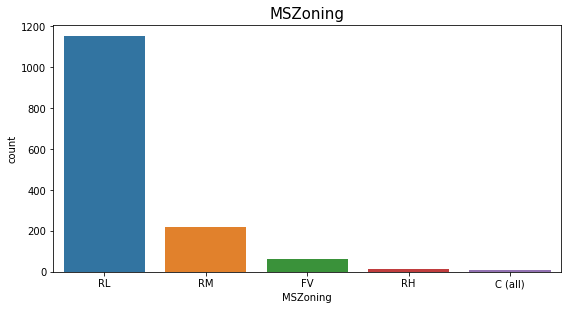

In [54]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='MSZoning', data=df_pd2, order=df_pd['MSZoning'].value_counts().index)
plt.title('MSZoning', fontsize=15)
plt.show()

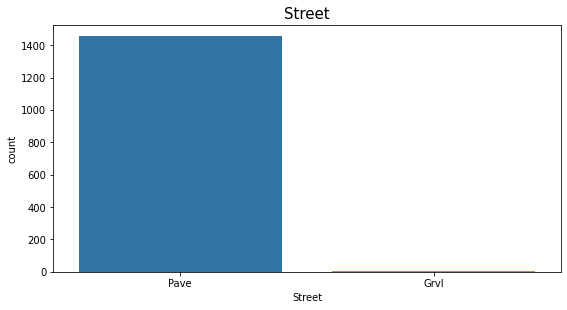

In [55]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='Street', data=df_pd2, order=df_pd['Street'].value_counts().index)
plt.title('Street', fontsize=15)
plt.show()

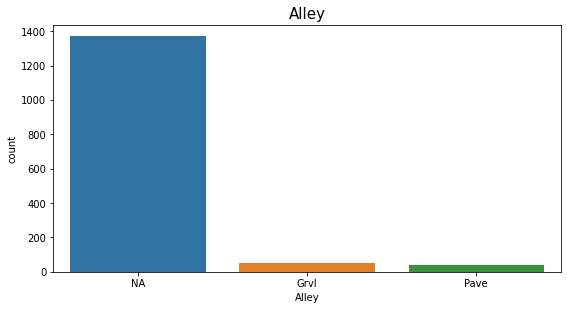

In [56]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='Alley', data=df_pd2, order=df_pd['Alley'].value_counts().index)
plt.title('Alley', fontsize=15)
plt.show()

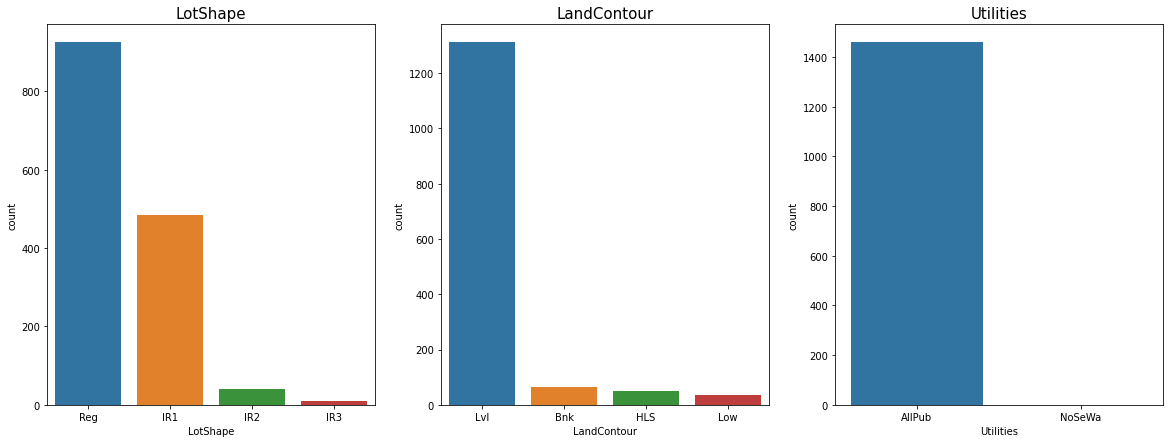

In [57]:
#Barchart for categorical variable
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(x='LotShape', data=df_pd2, order=df_pd['LotShape'].value_counts().index)
plt.title('LotShape', fontsize=15)
plt.subplot(132)
sns.countplot(x='LandContour', data=df_pd2, order=df_pd['LandContour'].value_counts().index)
plt.title('LandContour', fontsize=15)
plt.subplot(133)
sns.countplot(x='Utilities', data=df_pd2, order=df_pd['Utilities'].value_counts().index)
plt.title('Utilities', fontsize=15)
plt.show()

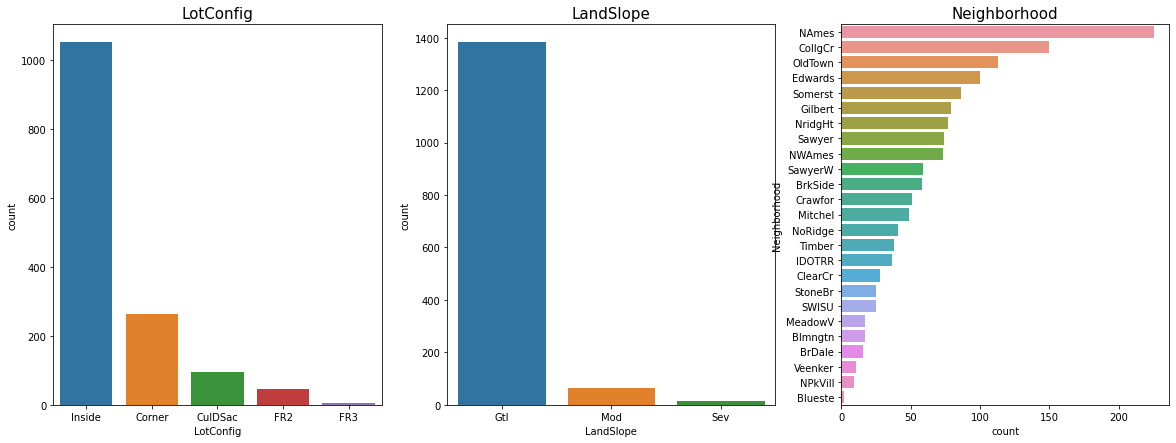

In [58]:
#Barchart for categorical variable
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(x='LotConfig', data=df_pd2, order=df_pd['LotConfig'].value_counts().index)
plt.title('LotConfig', fontsize=15)
plt.subplot(132)
sns.countplot(x='LandSlope', data=df_pd2, order=df_pd['LandSlope'].value_counts().index)
plt.title('LandSlope', fontsize=15)
plt.subplot(133)
sns.countplot(y='Neighborhood', data=df_pd2, order=df_pd['Neighborhood'].value_counts().index)
plt.title('Neighborhood', fontsize=15)
plt.show()

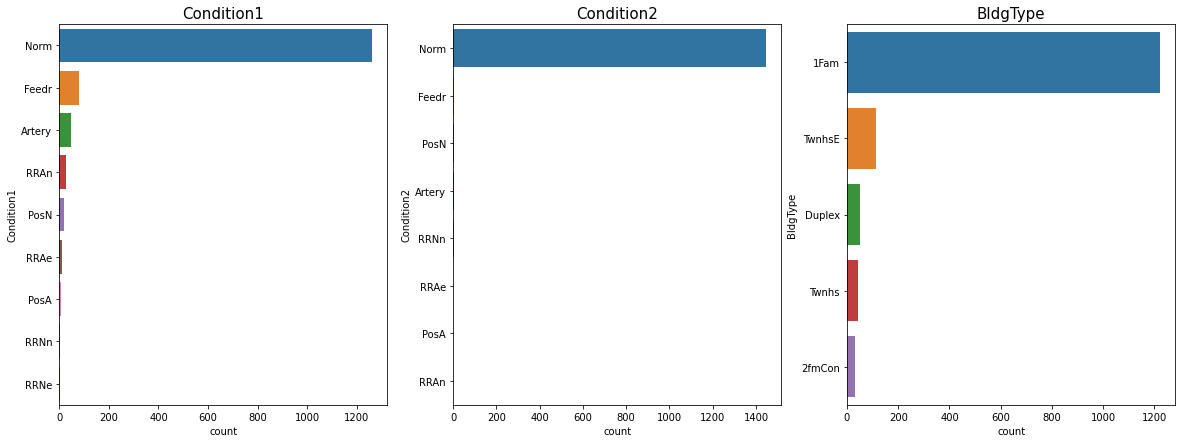

In [59]:
#Barchart for categorical variable
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(y='Condition1', data=df_pd2, order=df_pd['Condition1'].value_counts().index)
plt.title('Condition1', fontsize=15)
plt.subplot(132)
sns.countplot(y='Condition2', data=df_pd2, order=df_pd['Condition2'].value_counts().index)
plt.title('Condition2', fontsize=15)
plt.subplot(133)
sns.countplot(y='BldgType', data=df_pd2, order=df_pd['BldgType'].value_counts().index)
plt.title('BldgType', fontsize=15)
plt.show()

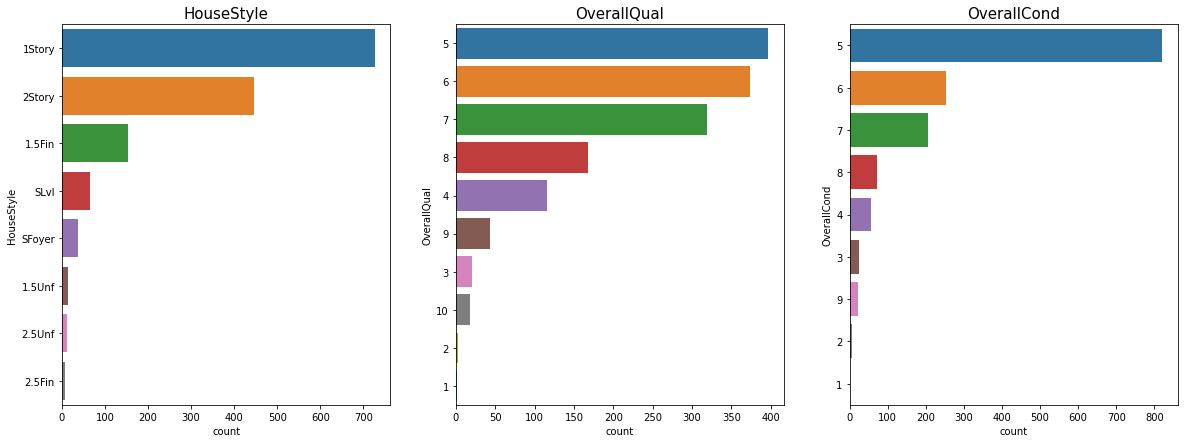

In [60]:
#Barchart for categorical variable
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(y='HouseStyle', data=df_pd2, order=df_pd['HouseStyle'].value_counts().index)
plt.title('HouseStyle', fontsize=15)
plt.subplot(132)
sns.countplot(y='OverallQual', data=df_pd2, order=df_pd['OverallQual'].value_counts().index)
plt.title('OverallQual', fontsize=15)
plt.subplot(133)
sns.countplot(y='OverallCond', data=df_pd2, order=df_pd['OverallCond'].value_counts().index)
plt.title('OverallCond', fontsize=15)
plt.show()

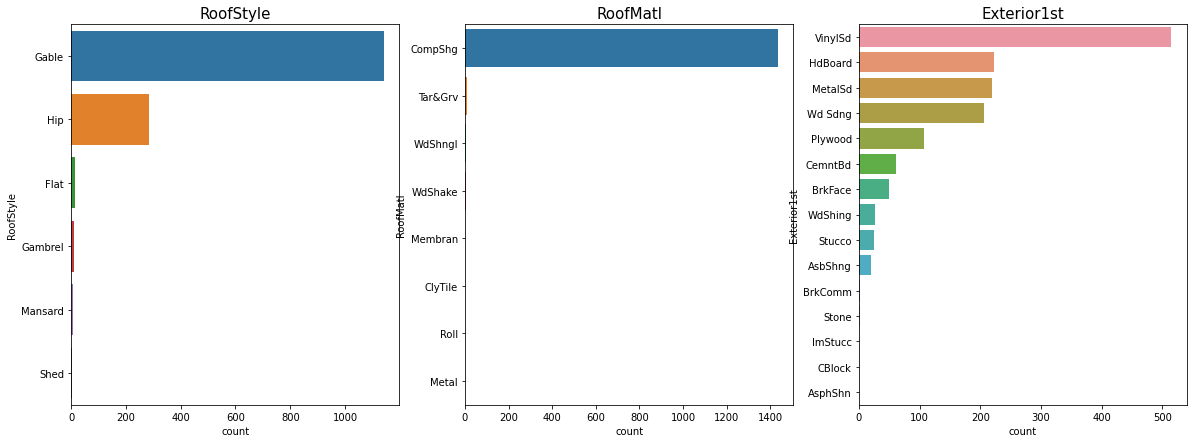

In [61]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(y='RoofStyle', data=df_pd2, order=df_pd['RoofStyle'].value_counts().index)
plt.title('RoofStyle', fontsize=15)
plt.subplot(132)
sns.countplot(y='RoofMatl', data=df_pd2, order=df_pd['RoofMatl'].value_counts().index)
plt.title('RoofMatl', fontsize=15)
plt.subplot(133)
sns.countplot(y='Exterior1st', data=df_pd2, order=df_pd['Exterior1st'].value_counts().index)
plt.title('Exterior1st', fontsize=15)
plt.show()

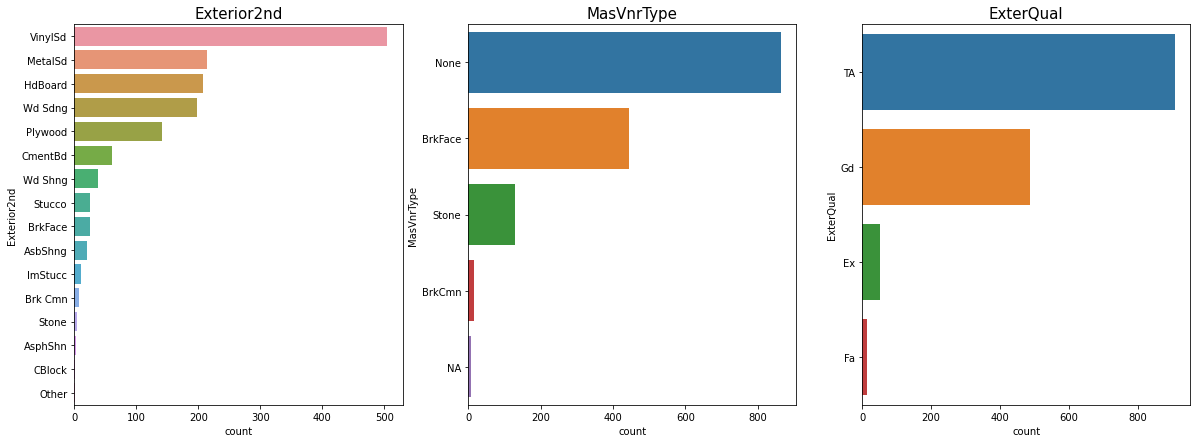

In [62]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(y='Exterior2nd', data=df_pd2, order=df_pd['Exterior2nd'].value_counts().index)
plt.title('Exterior2nd', fontsize=15)
plt.subplot(132)
sns.countplot(y='MasVnrType', data=df_pd2, order=df_pd['MasVnrType'].value_counts().index)
plt.title('MasVnrType', fontsize=15)
plt.subplot(133)
sns.countplot(y='ExterQual', data=df_pd2, order=df_pd['ExterQual'].value_counts().index)
plt.title('ExterQual', fontsize=15)
plt.show()

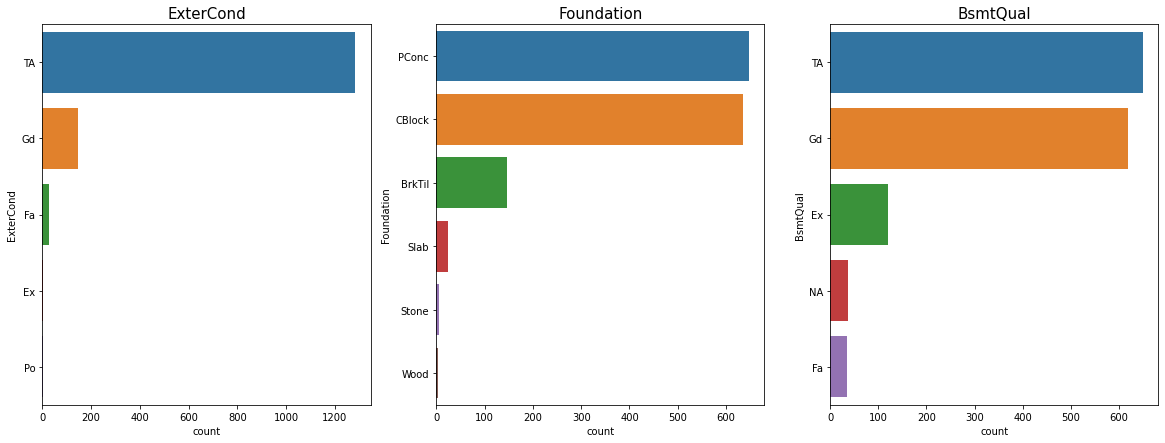

In [63]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(y='ExterCond', data=df_pd2, order=df_pd['ExterCond'].value_counts().index)
plt.title('ExterCond', fontsize=15)
plt.subplot(132)
sns.countplot(y='Foundation', data=df_pd2, order=df_pd['Foundation'].value_counts().index)
plt.title('Foundation', fontsize=15)
plt.subplot(133)
sns.countplot(y='BsmtQual', data=df_pd2, order=df_pd['BsmtQual'].value_counts().index)
plt.title('BsmtQual', fontsize=15)
plt.show()

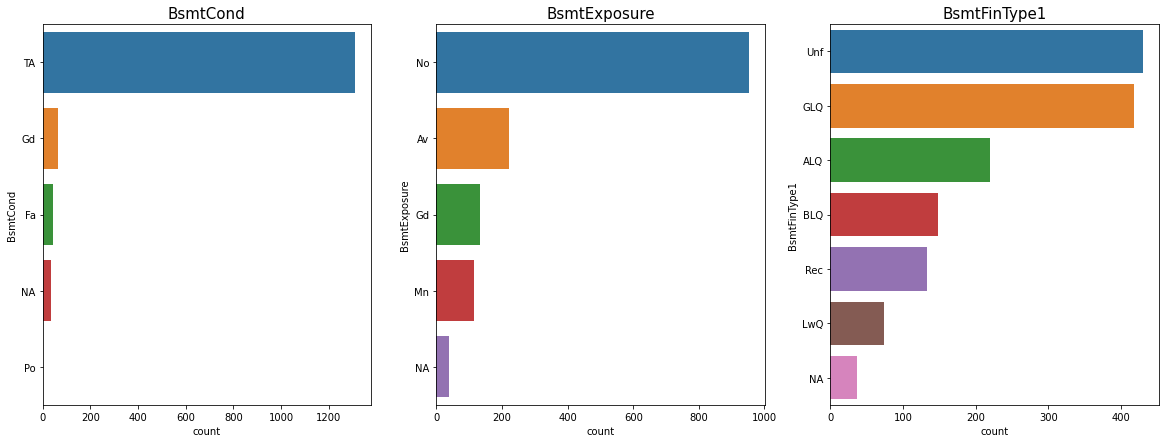

In [64]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(y='BsmtCond', data=df_pd2, order=df_pd['BsmtCond'].value_counts().index)
plt.title('BsmtCond', fontsize=15)
plt.subplot(132)
sns.countplot(y='BsmtExposure', data=df_pd2, order=df_pd['BsmtExposure'].value_counts().index)
plt.title('BsmtExposure', fontsize=15)
plt.subplot(133)
sns.countplot(y='BsmtFinType1', data=df_pd2, order=df_pd['BsmtFinType1'].value_counts().index)
plt.title('BsmtFinType1', fontsize=15)
plt.show()

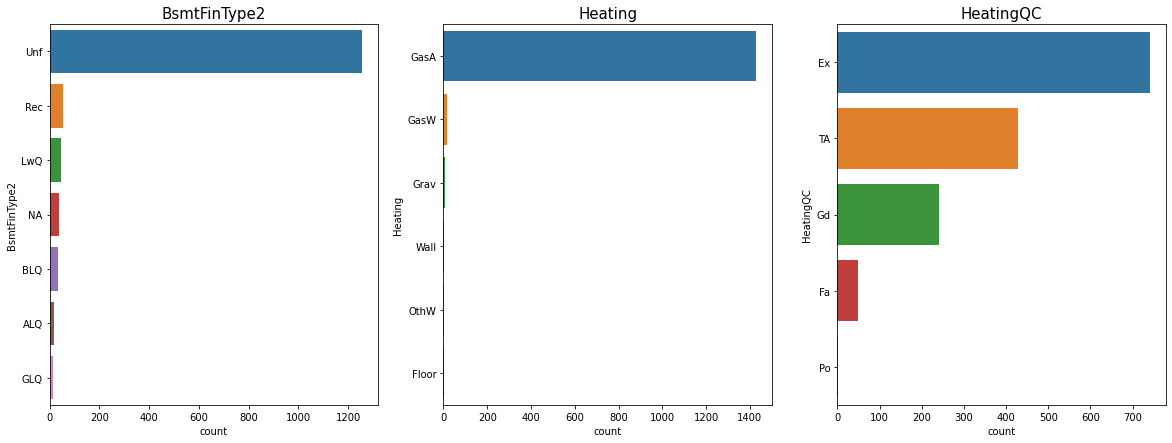

In [65]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(y='BsmtFinType2', data=df_pd2, order=df_pd['BsmtFinType2'].value_counts().index)
plt.title('BsmtFinType2', fontsize=15)
plt.subplot(132)
sns.countplot(y='Heating', data=df_pd2, order=df_pd['Heating'].value_counts().index)
plt.title('Heating', fontsize=15)
plt.subplot(133)
sns.countplot(y='HeatingQC', data=df_pd2, order=df_pd['HeatingQC'].value_counts().index)
plt.title('HeatingQC', fontsize=15)
plt.show()

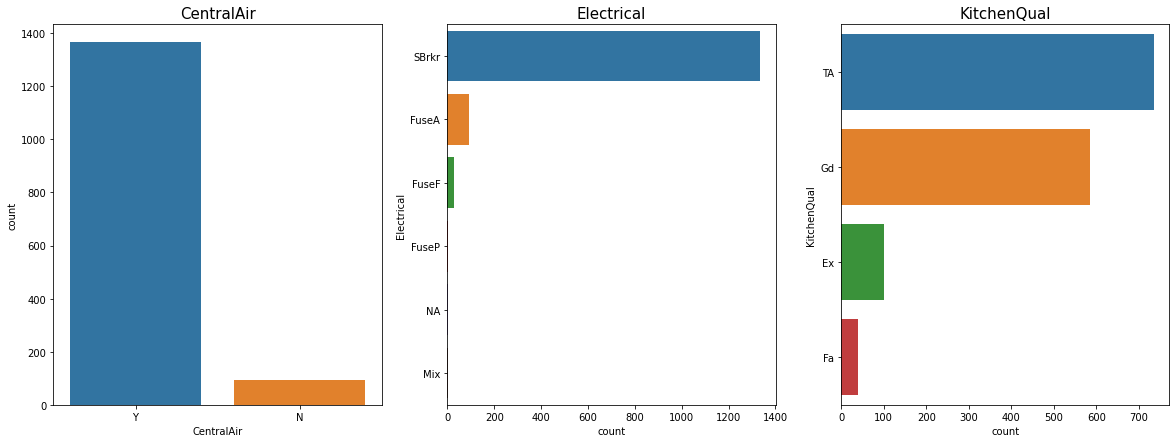

In [66]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(x='CentralAir', data=df_pd2, order=df_pd['CentralAir'].value_counts().index)
plt.title('CentralAir', fontsize=15)
plt.subplot(132)
sns.countplot(y='Electrical', data=df_pd2, order=df_pd['Electrical'].value_counts().index)
plt.title('Electrical', fontsize=15)
plt.subplot(133)
sns.countplot(y='KitchenQual', data=df_pd2, order=df_pd['KitchenQual'].value_counts().index)
plt.title('KitchenQual', fontsize=15)
plt.show()

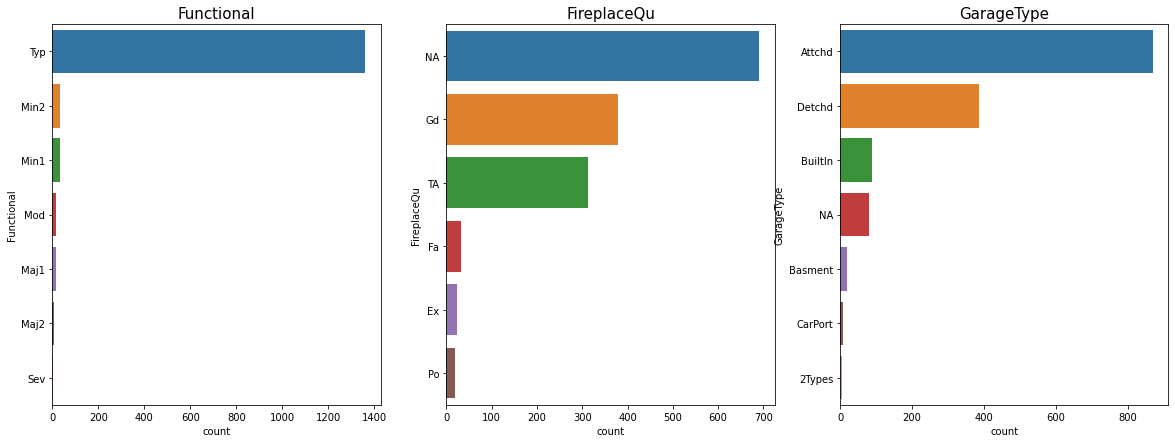

In [67]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(y='Functional', data=df_pd2, order=df_pd['Functional'].value_counts().index)
plt.title('Functional', fontsize=15)
plt.subplot(132)
sns.countplot(y='FireplaceQu', data=df_pd2, order=df_pd['FireplaceQu'].value_counts().index)
plt.title('FireplaceQu', fontsize=15)
plt.subplot(133)
sns.countplot(y='GarageType', data=df_pd2, order=df_pd['GarageType'].value_counts().index)
plt.title('GarageType', fontsize=15)
plt.show()

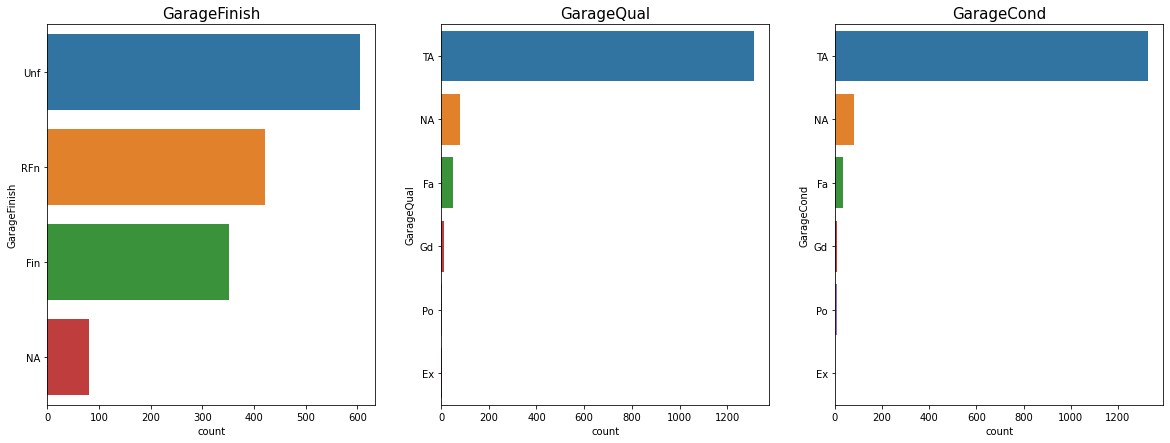

In [68]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(y='GarageFinish', data=df_pd2, order=df_pd['GarageFinish'].value_counts().index)
plt.title('GarageFinish', fontsize=15)
plt.subplot(132)
sns.countplot(y='GarageQual', data=df_pd2, order=df_pd['GarageQual'].value_counts().index)
plt.title('GarageQual', fontsize=15)
plt.subplot(133)
sns.countplot(y='GarageCond', data=df_pd2, order=df_pd['GarageCond'].value_counts().index)
plt.title('GarageCond', fontsize=15)
plt.show()

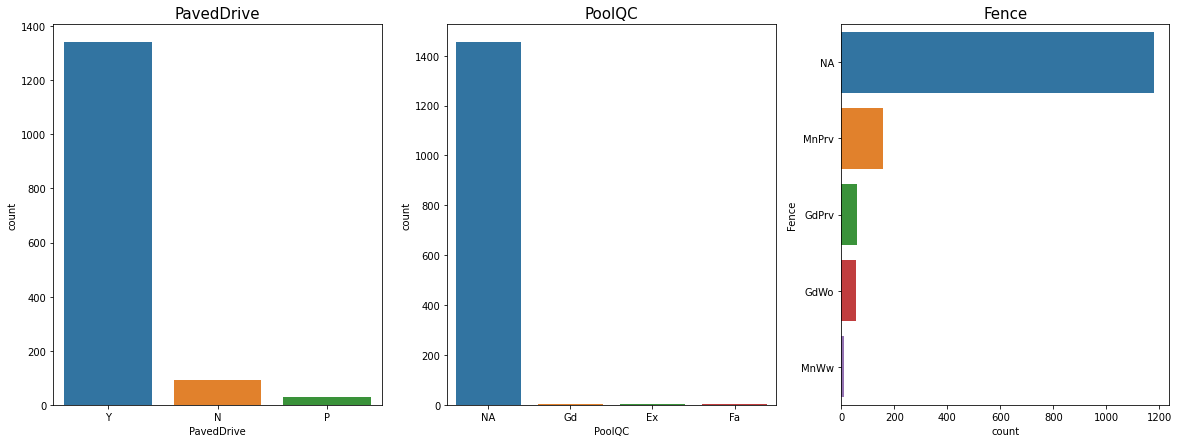

In [69]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(x='PavedDrive', data=df_pd2, order=df_pd['PavedDrive'].value_counts().index)
plt.title('PavedDrive', fontsize=15)
plt.subplot(132)
sns.countplot(x='PoolQC', data=df_pd2, order=df_pd['PoolQC'].value_counts().index)
plt.title('PoolQC', fontsize=15)
plt.subplot(133)
sns.countplot(y='Fence', data=df_pd2, order=df_pd['Fence'].value_counts().index)
plt.title('Fence', fontsize=15)
plt.show()

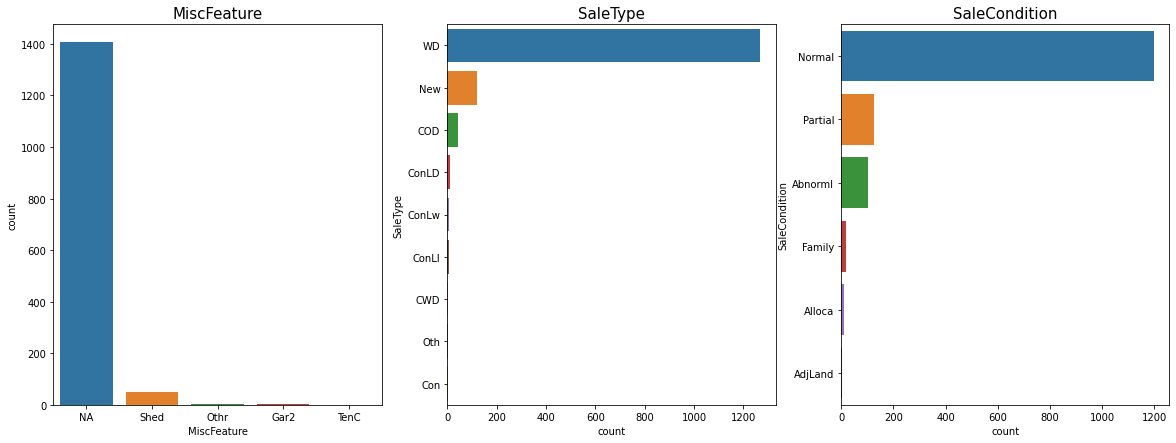

In [70]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(x='MiscFeature', data=df_pd2, order=df_pd['MiscFeature'].value_counts().index)
plt.title('MiscFeature', fontsize=15)
plt.subplot(132)
sns.countplot(y='SaleType', data=df_pd2, order=df_pd['SaleType'].value_counts().index)
plt.title('SaleType', fontsize=15)
plt.subplot(133)
sns.countplot(y='SaleCondition', data=df_pd2, order=df_pd['SaleCondition'].value_counts().index)
plt.title('SaleCondition', fontsize=15)
plt.show()

### Insignificant Categories in Train Data

In [71]:
df_percent=df_final.groupBy('Condition1').count().sort(col("count").desc())\
                    .withColumn('total',sum(col('count')).over(window))\
                    .withColumn('Percent',col('count')*100/col('total')) #calculate the percentage-save in Percent columns from each categories
df_percent.show()


+----------+-----+-----+------------------+
|Condition1|count|total|           Percent|
+----------+-----+-----+------------------+
|      Norm| 1260| 1460|  86.3013698630137|
|     Feedr|   81| 1460|5.5479452054794525|
|    Artery|   48| 1460| 3.287671232876712|
|      RRAn|   26| 1460|1.7808219178082192|
|      PosN|   19| 1460|1.3013698630136987|
|      RRAe|   11| 1460|0.7534246575342466|
|      PosA|    8| 1460| 0.547945205479452|
|      RRNn|    5| 1460|0.3424657534246575|
|      RRNe|    2| 1460| 0.136986301369863|
+----------+-----+-----+------------------+



In [72]:
threshold=97
threshold2=0.7

In [73]:
def replace_cat2(f,cols):
    """input are dataframe and categorical variables, replace insignificant categories (percentage <=0.7) with largest number
    of catgories and output is new dataframe """
    df_percent=f.groupBy(cols).count().sort(col("count").desc())\
                .withColumn('total',sum(col('count')).over(window))\
                .withColumn('Percent',col('count')*100/col('total')) #calculate the percentage-save in Percent columns from each categories
    dominant_cat=df_percent.select(df_percent['Percent']).collect()[0][0] #calculate the highest percentage of category
    count_dist=f.select([cols]).distinct().count() #calculate distinct values in that columns
    if count_dist > 2 and dominant_cat <= threshold :
        print('column:', cols)
        cols_names.append(cols)  #combine with previous list
        replacement=f.groupBy(cols).count().sort(col("count").desc()).collect()[0][0] #define dominant category 
        print("replacement:",replacement)
        replacing.append(replacement) #combine with previous list
        insign_cat=df_percent.filter(df_percent['Percent']< threshold2).select(df_percent[cols]).collect() #calculate insignificant categories
        insign_cat=[r[cols] for r in insign_cat] #just take the values
        category.append(insign_cat) #combine with previous list
        print("insign_cat:",insign_cat)
        f=f.replace(insign_cat,replacement, cols) #replace insignificant categories with dominant categories
    return f
    

In [74]:
#call function replacing insignificant categories 
replacing=[]
cols_names=[]
category=[]
for cols in cat_cols:
    df_final=replace_cat2(df_final,cols)

column: MSZoning
replacement: RL
insign_cat: ['C (all)']
column: Alley
replacement: NA
insign_cat: []
column: LotShape
replacement: Reg
insign_cat: ['IR3']
column: LandContour
replacement: Lvl
insign_cat: []
column: LotConfig
replacement: Inside
insign_cat: ['FR3']
column: LandSlope
replacement: Gtl
insign_cat: []
column: Neighborhood
replacement: NAmes
insign_cat: ['NPkVill', 'Blueste']
column: Condition1
replacement: Norm
insign_cat: ['PosA', 'RRNn', 'RRNe']
column: BldgType
replacement: 1Fam
insign_cat: []
column: HouseStyle
replacement: 1Story
insign_cat: ['2.5Fin']
column: OverallQual
replacement: 5
insign_cat: ['2', '1']
column: OverallCond
replacement: 5
insign_cat: ['2', '1']
column: RoofStyle
replacement: Gable
insign_cat: ['Mansard', 'Shed']
column: Exterior1st
replacement: VinylSd
insign_cat: ['Stone', 'BrkComm', 'AsphShn', 'ImStucc', 'CBlock']
column: Exterior2nd
replacement: VinylSd
insign_cat: ['ImStucc', 'Brk Cmn', 'Stone', 'AsphShn', 'Other', 'CBlock']
column: MasVnrTyp

In [75]:
#check length in list cols_names, category and replacing
len(cols_names), len(category), len(replacing)


(38, 38, 38)

In [76]:
#Create dataframe of replaced categories
g=spark.createDataFrame(list(zip(cols_names, replacing, category)),['cols_names', 'replacing', 'category'])
g.show(9)

+------------+---------+------------------+
|  cols_names|replacing|          category|
+------------+---------+------------------+
|    MSZoning|       RL|         [C (all)]|
|       Alley|       NA|                []|
|    LotShape|      Reg|             [IR3]|
| LandContour|      Lvl|                []|
|   LotConfig|   Inside|             [FR3]|
|   LandSlope|      Gtl|                []|
|Neighborhood|    NAmes|[NPkVill, Blueste]|
|  Condition1|     Norm|[PosA, RRNn, RRNe]|
|    BldgType|     1Fam|                []|
+------------+---------+------------------+
only showing top 9 rows



In [77]:
g.dtypes

[('cols_names', 'string'),
 ('replacing', 'string'),
 ('category', 'array<string>')]

In [78]:
g.printSchema()

root
 |-- cols_names: string (nullable = true)
 |-- replacing: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [79]:
f_percent=df_final.groupBy('MSZoning').count().sort(col("count").desc())\
                       .withColumn('total',sum(col('count')).over(window))\
                       .withColumn('Percent',col('count')*100/col('total'))

f_percent.show()


+--------+-----+-----+------------------+
|MSZoning|count|total|           Percent|
+--------+-----+-----+------------------+
|      RL| 1161| 1460| 79.52054794520548|
|      RM|  218| 1460|14.931506849315069|
|      FV|   65| 1460|4.4520547945205475|
|      RH|   16| 1460| 1.095890410958904|
+--------+-----+-----+------------------+



### Replacing Insignificant Categories in data test

In [80]:
#view g dataframe
g.show(15)

+------------+---------+--------------------+
|  cols_names|replacing|            category|
+------------+---------+--------------------+
|    MSZoning|       RL|           [C (all)]|
|       Alley|       NA|                  []|
|    LotShape|      Reg|               [IR3]|
| LandContour|      Lvl|                  []|
|   LotConfig|   Inside|               [FR3]|
|   LandSlope|      Gtl|                  []|
|Neighborhood|    NAmes|  [NPkVill, Blueste]|
|  Condition1|     Norm|  [PosA, RRNn, RRNe]|
|    BldgType|     1Fam|                  []|
|  HouseStyle|   1Story|            [2.5Fin]|
| OverallQual|        5|              [2, 1]|
| OverallCond|        5|              [2, 1]|
|   RoofStyle|    Gable|     [Mansard, Shed]|
| Exterior1st|  VinylSd|[Stone, BrkComm, ...|
| Exterior2nd|  VinylSd|[ImStucc, Brk Cmn...|
+------------+---------+--------------------+
only showing top 15 rows



In [81]:
cols_names_list=g.select('cols_names').collect() #select just cols_names from dataframe g
cols_names_list=[r['cols_names'] for r in cols_names_list] #take just the values
for z in cols_names_list:
    print('cols_names:',z)
    replacement_cat=g.filter(g['cols_names']== z).select(g['replacing']).collect()[0][0] #select values of replacing columns accoring to z in cols_names 
    print('replacement_cat:', replacement_cat)
    insignificant_cat=g.filter(g['cols_names']== z).select(g['category']).collect()[0][0] #select values of category columns accoring to z in cols_names
    print('insignificant_cat:',insignificant_cat)
    test_data=test_data.replace(insignificant_cat,replacement_cat, z) #replace insignificant cat with replacement value



cols_names: MSZoning
replacement_cat: RL
insignificant_cat: ['C (all)']
cols_names: Alley
replacement_cat: NA
insignificant_cat: []
cols_names: LotShape
replacement_cat: Reg
insignificant_cat: ['IR3']
cols_names: LandContour
replacement_cat: Lvl
insignificant_cat: []
cols_names: LotConfig
replacement_cat: Inside
insignificant_cat: ['FR3']
cols_names: LandSlope
replacement_cat: Gtl
insignificant_cat: []
cols_names: Neighborhood
replacement_cat: NAmes
insignificant_cat: ['NPkVill', 'Blueste']
cols_names: Condition1
replacement_cat: Norm
insignificant_cat: ['PosA', 'RRNn', 'RRNe']
cols_names: BldgType
replacement_cat: 1Fam
insignificant_cat: []
cols_names: HouseStyle
replacement_cat: 1Story
insignificant_cat: ['2.5Fin']
cols_names: OverallQual
replacement_cat: 5
insignificant_cat: ['2', '1']
cols_names: OverallCond
replacement_cat: 5
insignificant_cat: ['2', '1']
cols_names: RoofStyle
replacement_cat: Gable
insignificant_cat: ['Mansard', 'Shed']
cols_names: Exterior1st
replacement_cat: Vi

In [82]:
percent=df_final.groupBy('Exterior1st').count().sort(col("count").desc())\
                       .withColumn('total',sum(col('count')).over(window))\
                       .withColumn('Percent',col('count')*100/col('total'))
percent.show()


+-----------+-----+-----+------------------+
|Exterior1st|count|total|           Percent|
+-----------+-----+-----+------------------+
|    VinylSd|  522| 1460| 35.75342465753425|
|    HdBoard|  222| 1460|15.205479452054794|
|    MetalSd|  220| 1460|15.068493150684931|
|    Wd Sdng|  206| 1460| 14.10958904109589|
|    Plywood|  108| 1460| 7.397260273972603|
|    CemntBd|   61| 1460| 4.178082191780822|
|    BrkFace|   50| 1460|3.4246575342465753|
|    WdShing|   26| 1460|1.7808219178082192|
|     Stucco|   25| 1460|1.7123287671232876|
|    AsbShng|   20| 1460|  1.36986301369863|
+-----------+-----+-----+------------------+



In [83]:
f_percent=test_data.groupBy('Exterior1st').count().sort(col("count").desc())\
                       .withColumn('total',sum(col('count')).over(window))\
                       .withColumn('Percent',col('count')*100/col('total'))
f_percent.show()


+-----------+-----+-----+------------------+
|Exterior1st|count|total|           Percent|
+-----------+-----+-----+------------------+
|    VinylSd|  517| 1459| 35.43522960932145|
|    MetalSd|  230| 1459|15.764222069910899|
|    HdBoard|  220| 1459|15.078821110349555|
|    Wd Sdng|  205| 1459| 14.05071967100754|
|    Plywood|  113| 1459|  7.74503084304318|
|    CemntBd|   65| 1459| 4.455106237148732|
|    BrkFace|   37| 1459|2.5359835503769705|
|    WdShing|   30| 1459|2.0562028786840303|
|    AsbShng|   24| 1459|1.6449623029472242|
|     Stucco|   18| 1459|1.2337217272104182|
+-----------+-----+-----+------------------+



### Numerical Variables

We have so many numerical variable and they are 

In [84]:
len(num_cols)

34

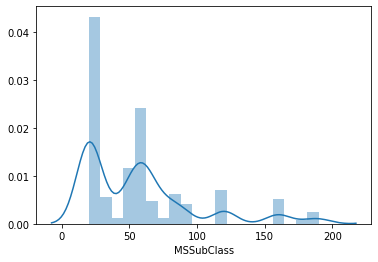

In [85]:
#distribusi of MSSubClass
sns.distplot(df_pd2['MSSubClass'])
plt.show()

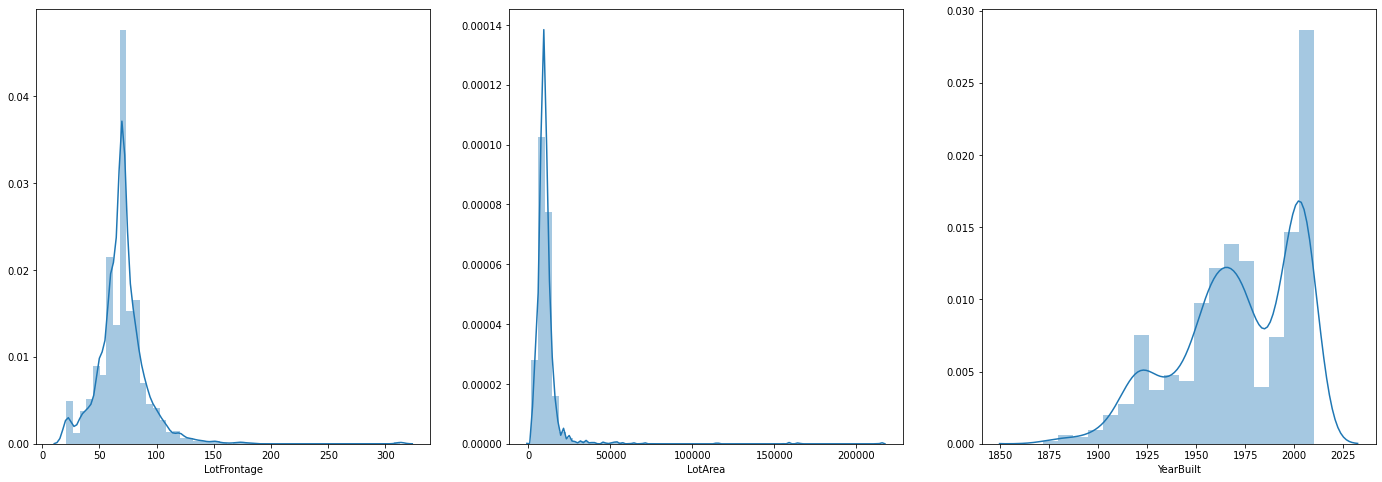

In [86]:
#distribusi of LotFrontage, LotArea and YearBuilt
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['LotFrontage'])
plt.subplot(132)
sns.distplot(df_pd2['LotArea'])
plt.subplot(133)
sns.distplot(df_pd2['YearBuilt'])
plt.show()

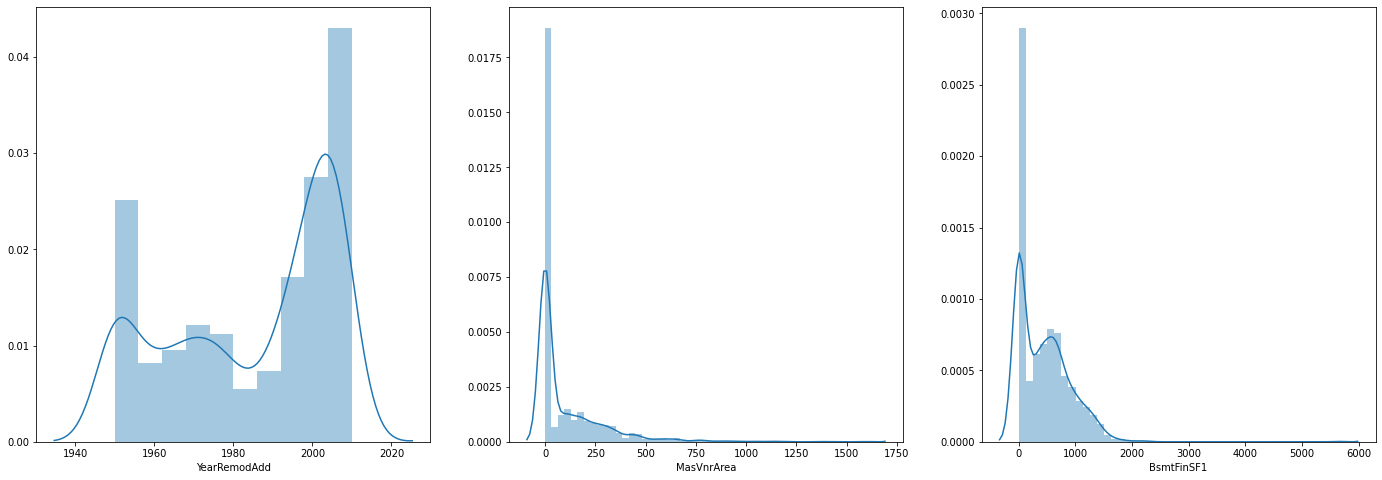

In [87]:
#distribusi of BsmtFinSF1, MasVnrArea and YearRemodAdd
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['YearRemodAdd'])
plt.subplot(132)
sns.distplot(df_pd2['MasVnrArea'])
plt.subplot(133)
sns.distplot(df_pd2['BsmtFinSF1'])
plt.show()

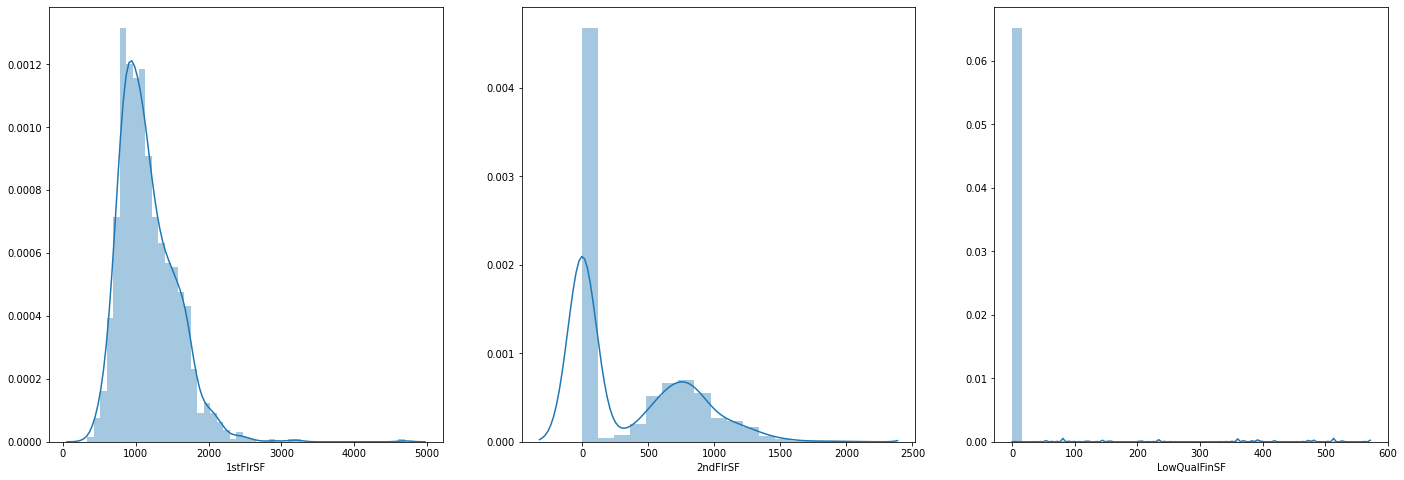

In [88]:
#distribusi of 1stFlrSF, 2ndFlrSF and LowQualFinSF
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['1stFlrSF'])
plt.subplot(132)
sns.distplot(df_pd2['2ndFlrSF'])
plt.subplot(133)
sns.distplot(df_pd2['LowQualFinSF'])
plt.show()

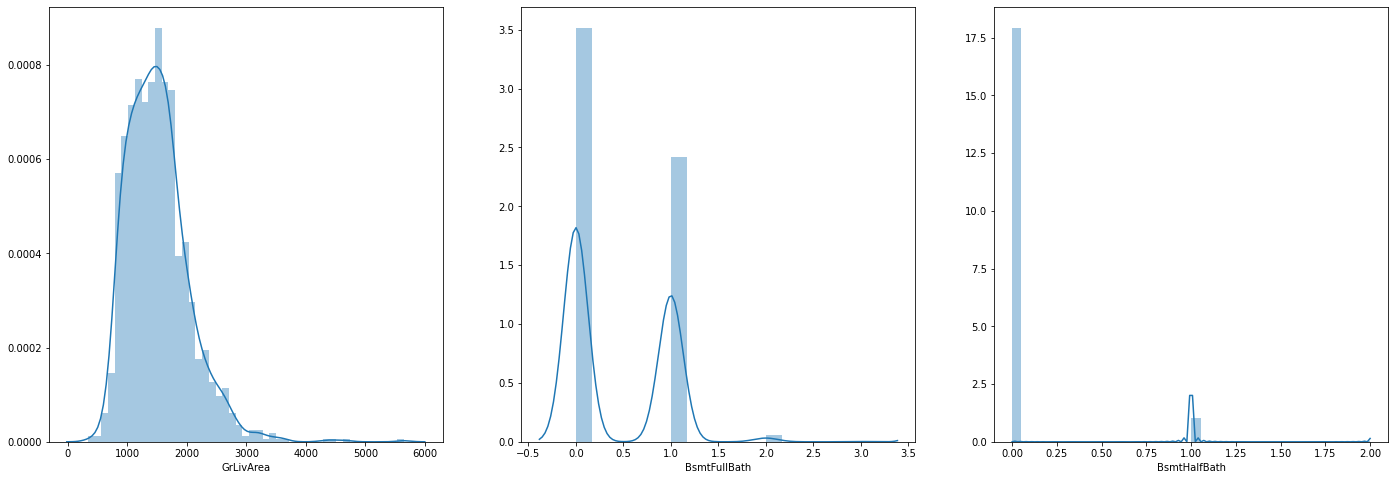

In [89]:
#distribusi of GrLivArea, BsmtFullBath and BsmtHalfBath
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['GrLivArea'])
plt.subplot(132)
sns.distplot(df_pd2['BsmtFullBath'])
plt.subplot(133)
sns.distplot(df_pd2['BsmtHalfBath'])
plt.show()

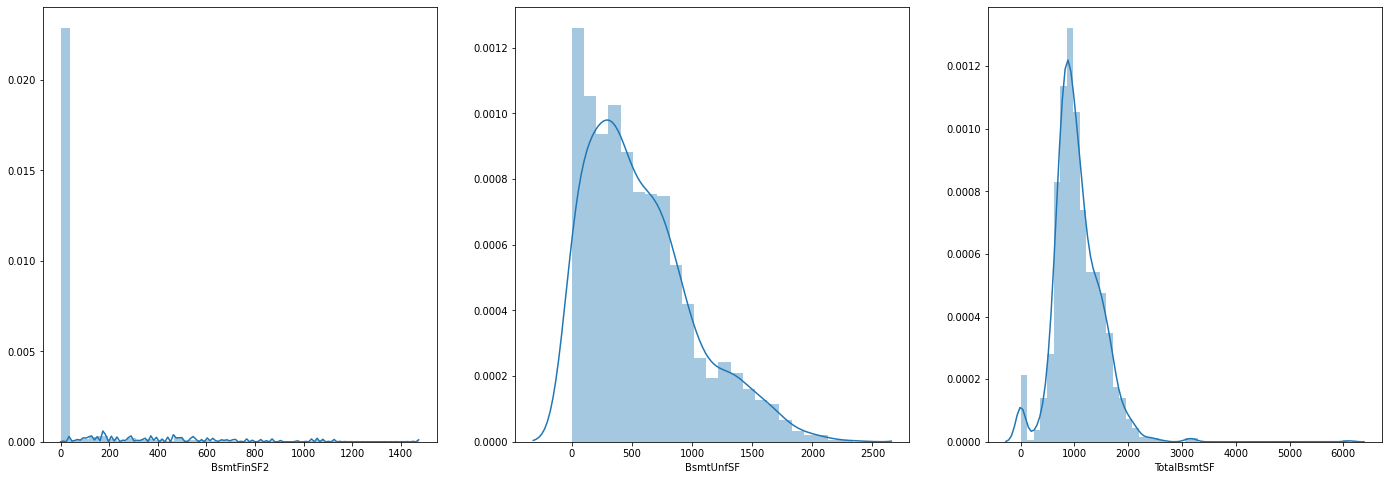

In [90]:
#distribusi of BsmtFinSF2, BsmtUnfSF and TotalBsmtSF
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['BsmtFinSF2'])
plt.subplot(132)
sns.distplot(df_pd2['BsmtUnfSF'])
plt.subplot(133)
sns.distplot(df_pd2['TotalBsmtSF'])
plt.show()

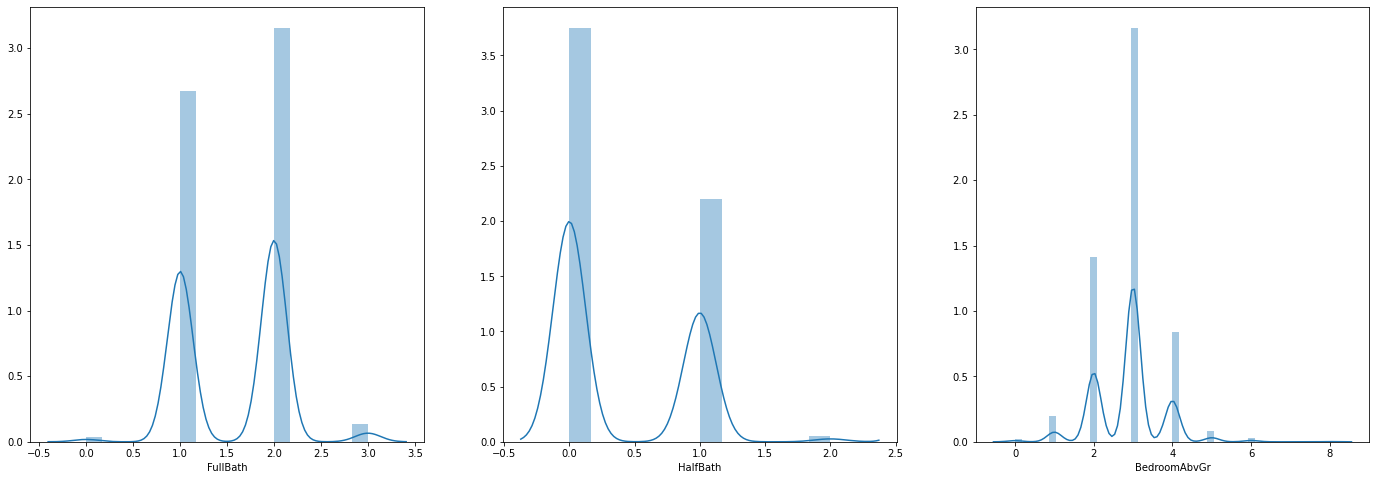

In [91]:
#distribusi of FullBath, HalfBath and BedroomAbvGr
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['FullBath'])
plt.subplot(132)
sns.distplot(df_pd2['HalfBath'])
plt.subplot(133)
sns.distplot(df_pd2['BedroomAbvGr'])
plt.show()

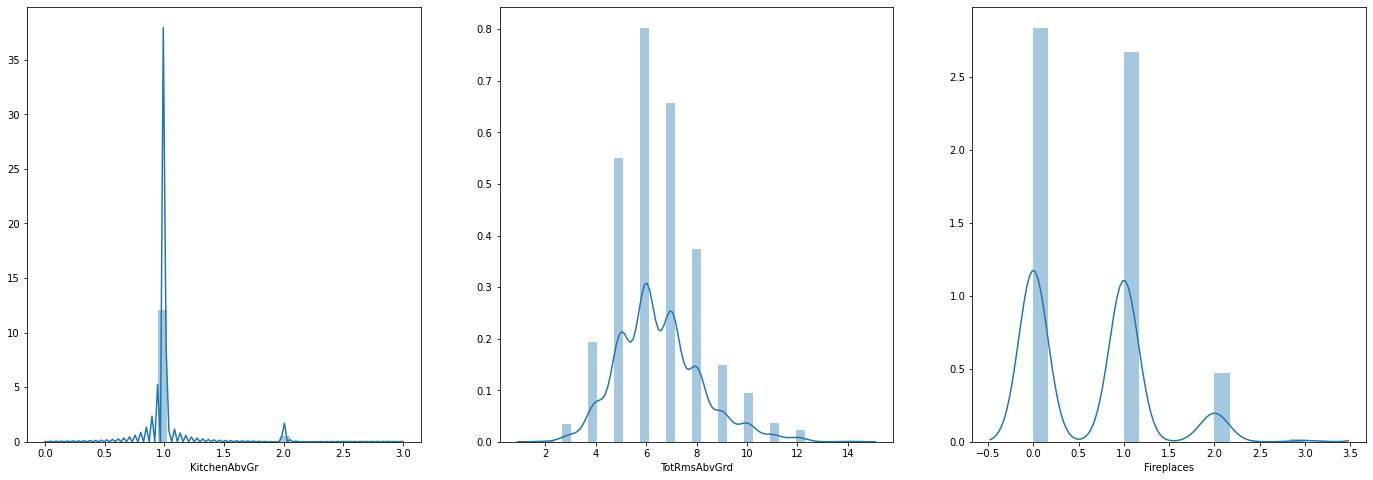

In [92]:
#distribusi of KitchenAbvGr, TotRmsAbvGrd and Fireplaces
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['KitchenAbvGr'])
plt.subplot(132)
sns.distplot(df_pd2['TotRmsAbvGrd'])
plt.subplot(133)
sns.distplot(df_pd2['Fireplaces'])
plt.show()


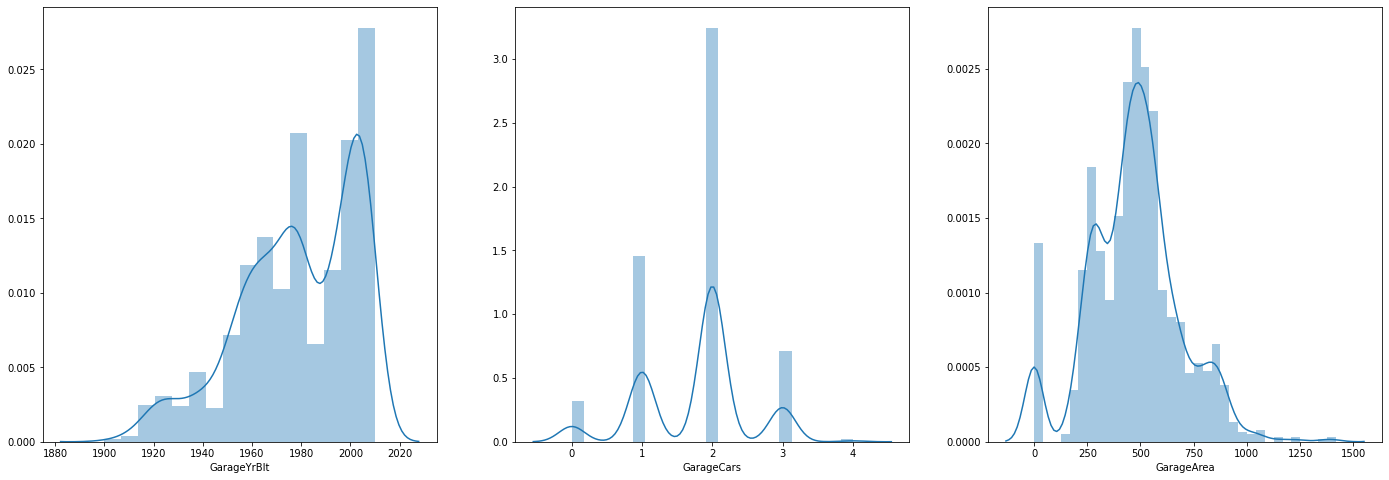

In [93]:
#distribusi of GarageYrBlt, GarageCars and GarageArea
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['GarageYrBlt'])
plt.subplot(132)
sns.distplot(df_pd2['GarageCars'])
plt.subplot(133)
sns.distplot(df_pd2['GarageArea'])
plt.show()

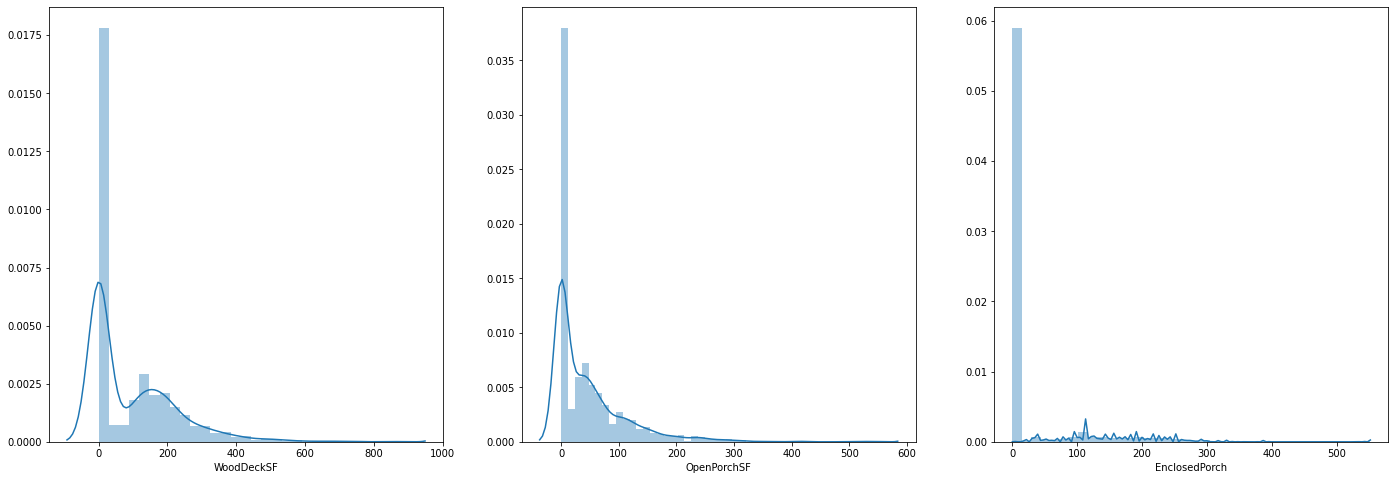

In [94]:
#distribusi of WoodDeckSF, OpenPorchSF and EnclosedPorch
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['WoodDeckSF'])
plt.subplot(132)
sns.distplot(df_pd2['OpenPorchSF'])
plt.subplot(133)
sns.distplot(df_pd2['EnclosedPorch'])
plt.show()


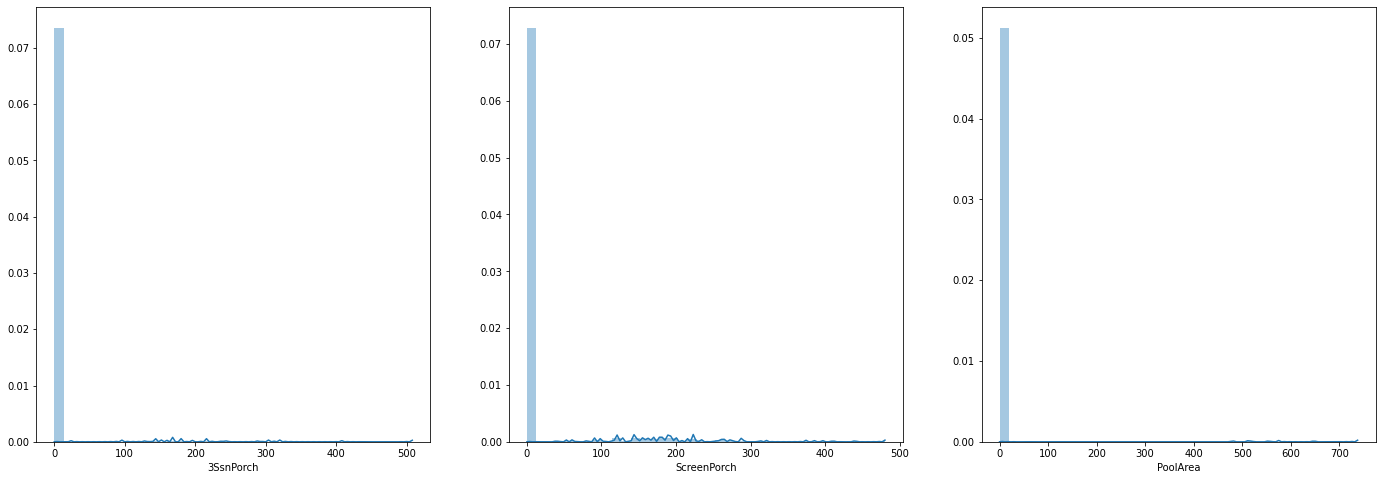

In [95]:
#distribusi of 3SsnPorch, ScreenPorch and PoolArea
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['3SsnPorch'])
plt.subplot(132)
sns.distplot(df_pd2['ScreenPorch'])
plt.subplot(133)
sns.distplot(df_pd2['PoolArea'])
plt.show()


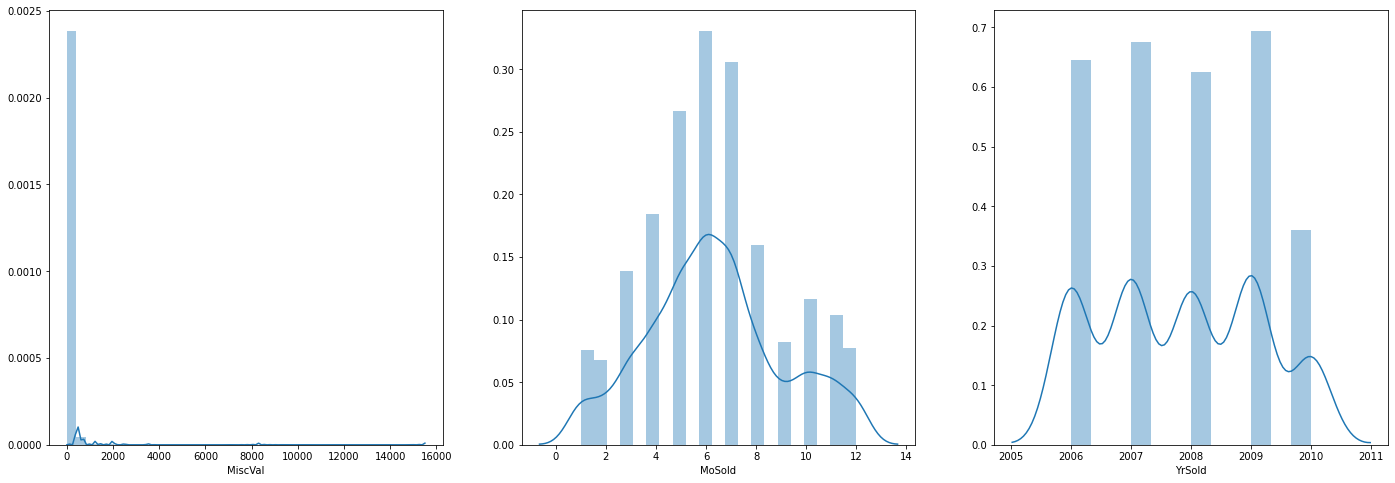

In [96]:
#distribusi of MiscVal, MoSold and YrSold
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd2['MiscVal'])
plt.subplot(132)
sns.distplot(df_pd2['MoSold'])
plt.subplot(133)
sns.distplot(df_pd2['YrSold'])
plt.show()

### Checking outlier

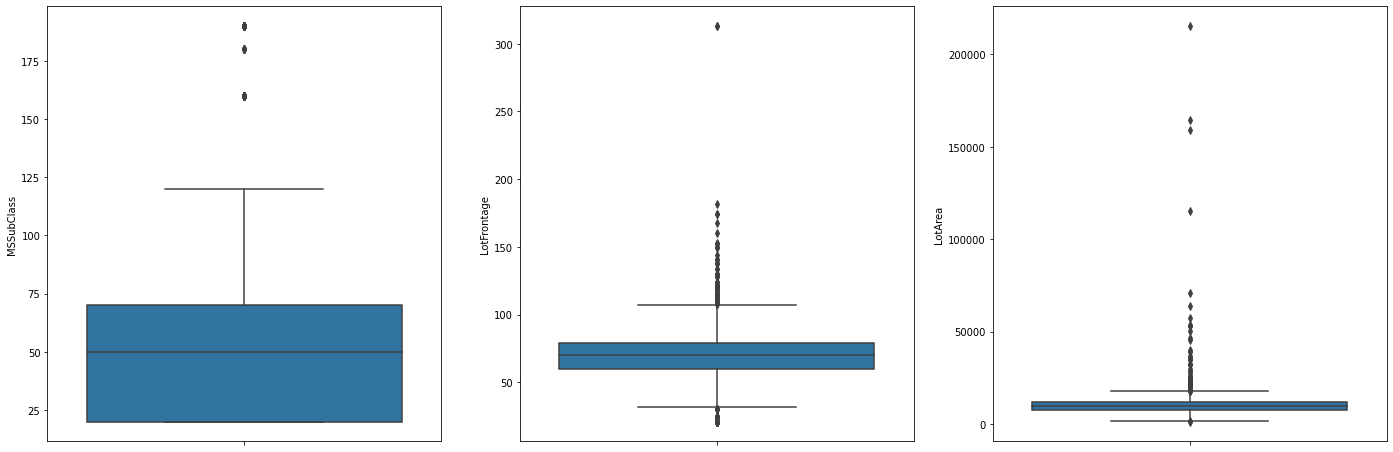

In [97]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="MSSubClass",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="LotFrontage",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="LotArea",data=df_pd2)
plt.show()


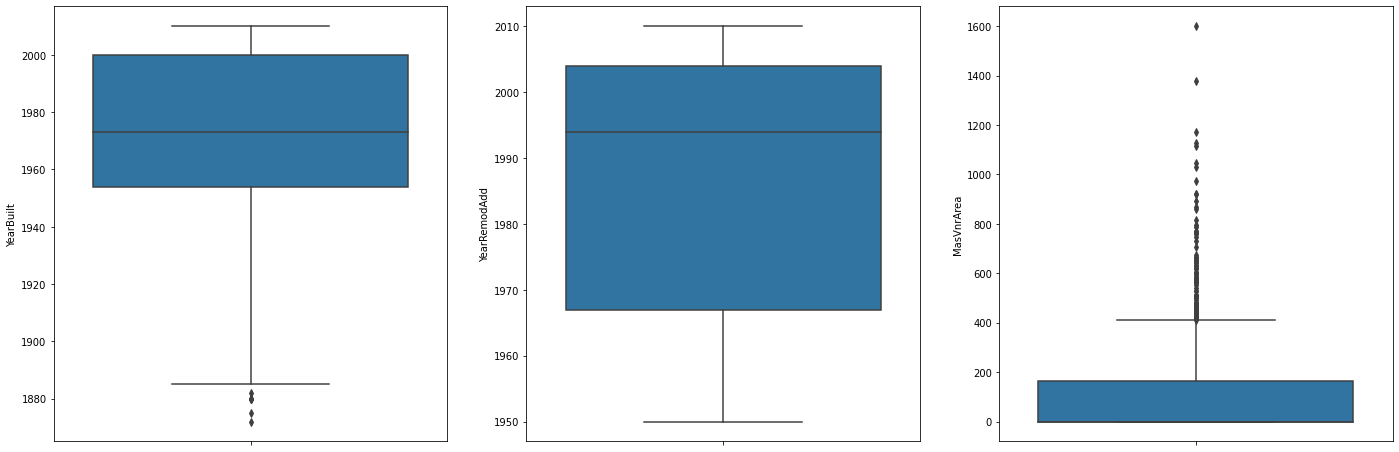

In [98]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="YearBuilt",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="YearRemodAdd",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="MasVnrArea",data=df_pd2)
plt.show()


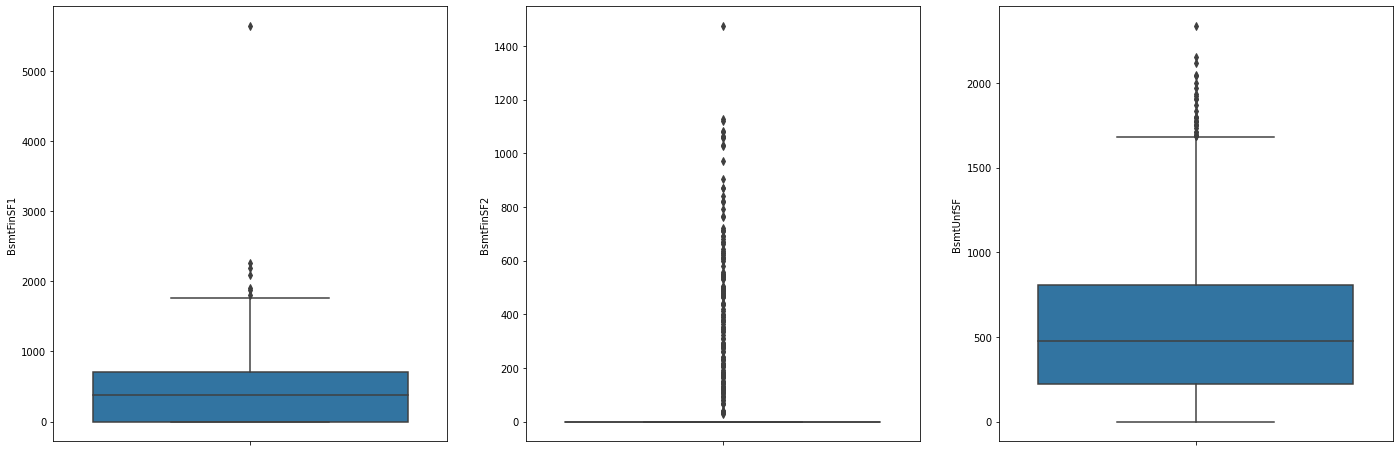

In [99]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="BsmtFinSF1",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="BsmtFinSF2",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="BsmtUnfSF",data=df_pd2)
plt.show()

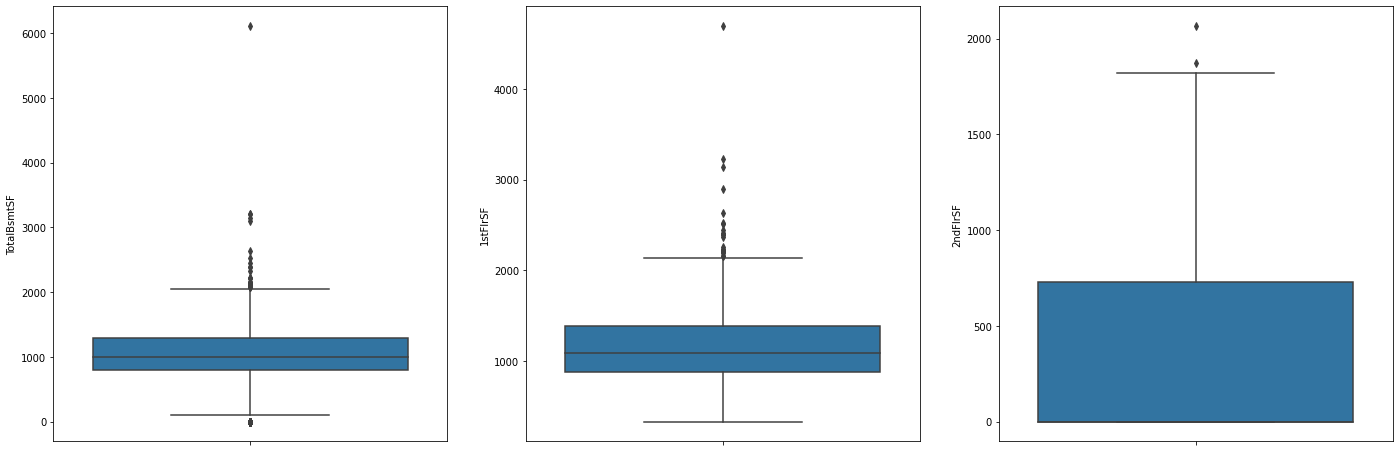

In [100]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="TotalBsmtSF",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="1stFlrSF",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="2ndFlrSF",data=df_pd2)
plt.show()


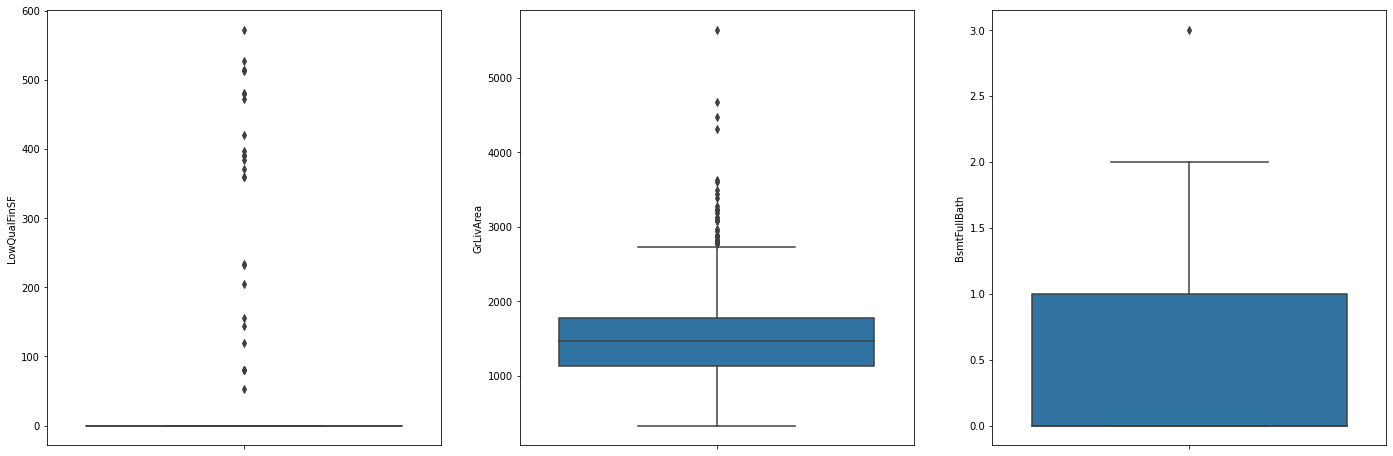

In [101]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="LowQualFinSF",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="GrLivArea",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="BsmtFullBath",data=df_pd2)
plt.show()


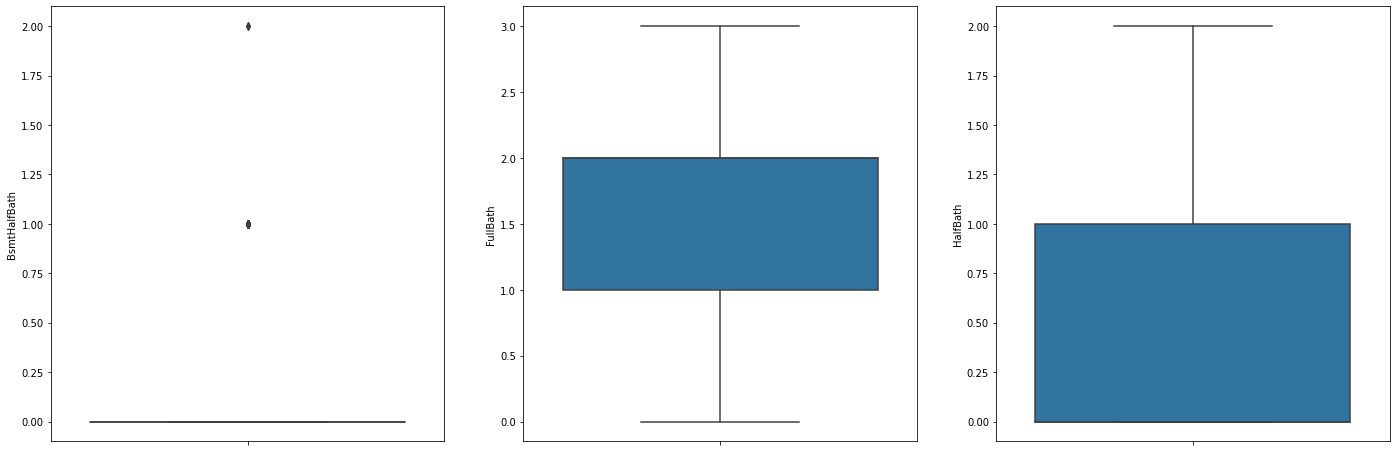

In [102]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="BsmtHalfBath",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="FullBath",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="HalfBath",data=df_pd2)
plt.show()

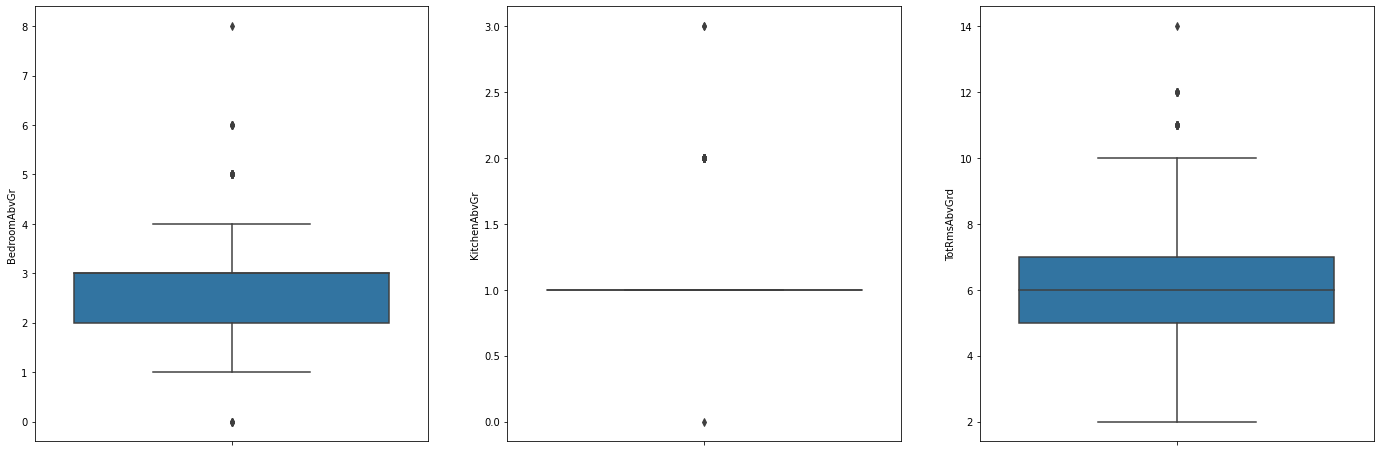

In [103]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="BedroomAbvGr",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="KitchenAbvGr",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="TotRmsAbvGrd",data=df_pd2)
plt.show()


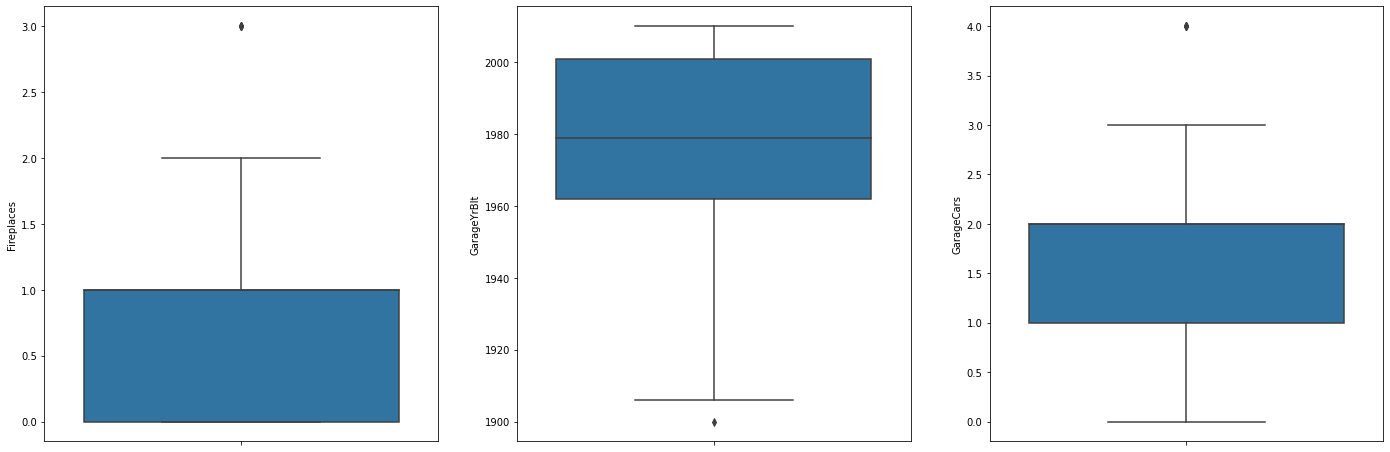

In [104]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="Fireplaces",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="GarageYrBlt",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="GarageCars",data=df_pd2)
plt.show()


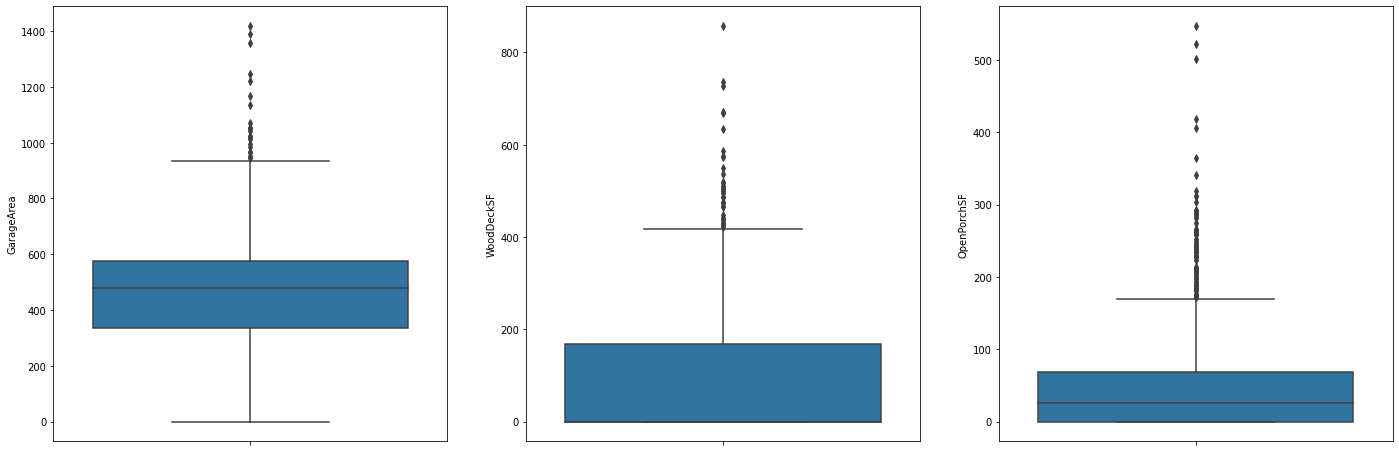

In [105]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="GarageArea",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="WoodDeckSF",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="OpenPorchSF",data=df_pd2)
plt.show()

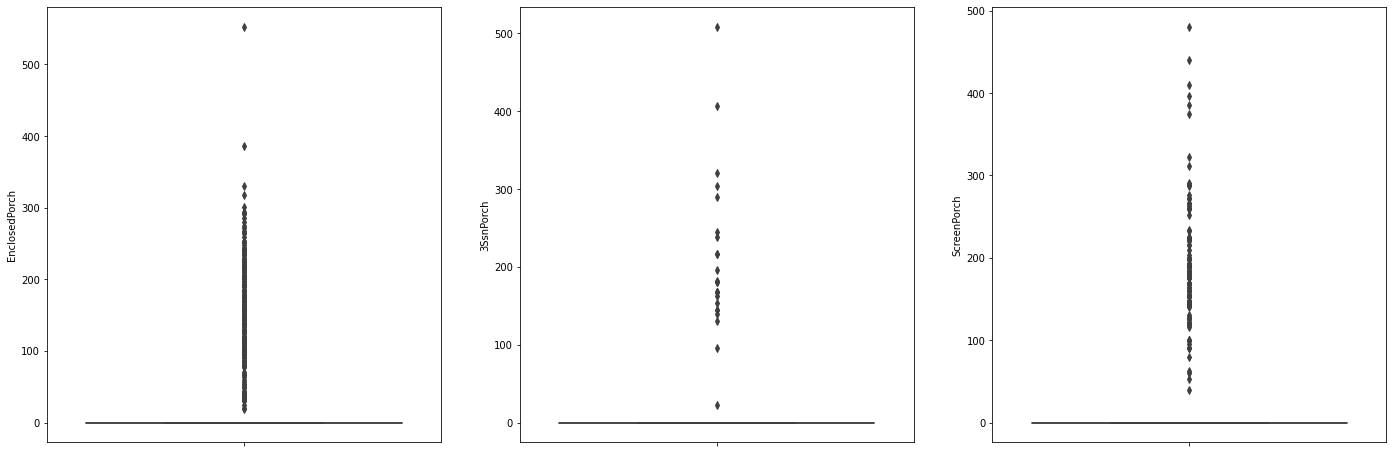

In [106]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="EnclosedPorch",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="3SsnPorch",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="ScreenPorch",data=df_pd2)
plt.show()

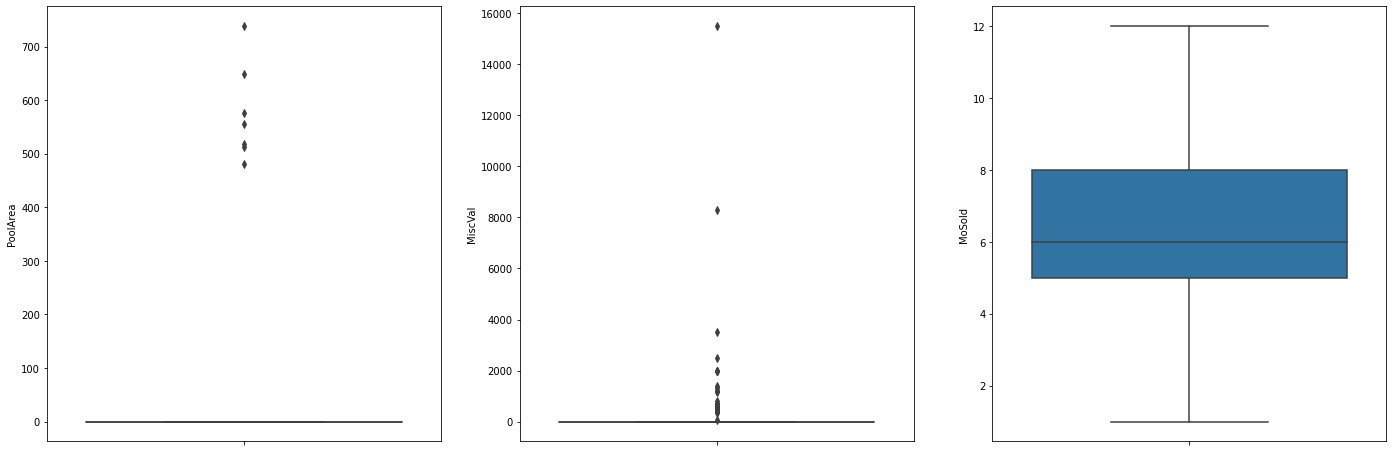

In [107]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.boxplot(y="PoolArea",data=df_pd2)
plt.subplot(132)
sns.boxplot(y="MiscVal",data=df_pd2)
plt.subplot(133)
sns.boxplot(y="MoSold",data=df_pd2)
plt.show()



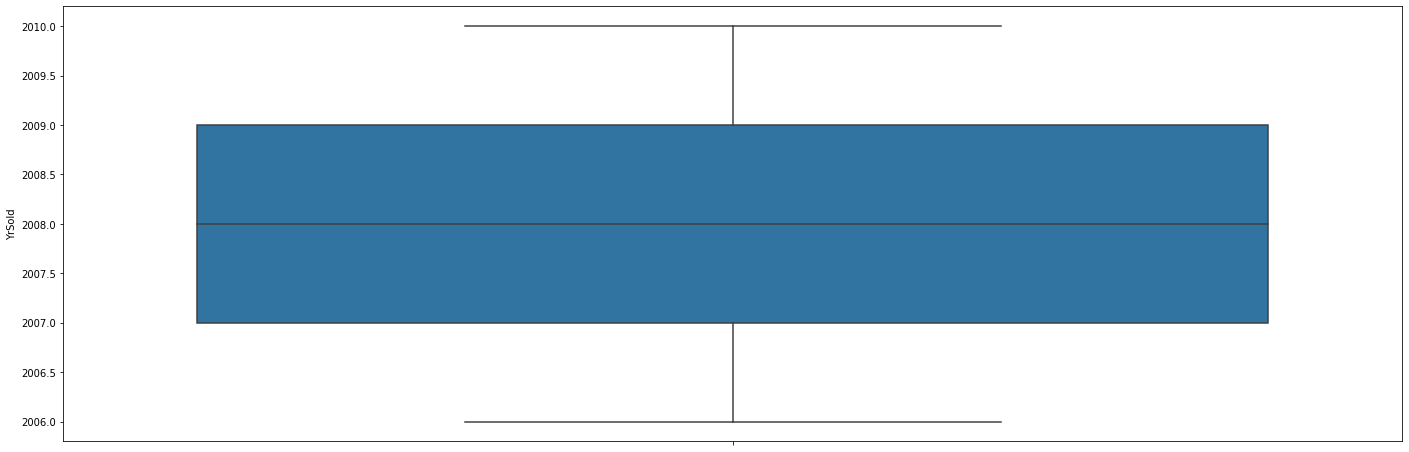

In [108]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
#plt.subplot(131)
sns.boxplot(y="YrSold",data=df_pd2)
plt.show()


### Handle of outlier in Train Data

In [109]:
df_pd2.describe()

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,label
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.041096,10516.828082,1971.267808,1984.865753,103.686986,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.533562,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.024031,9981.264932,30.202904,20.645407,180.569114,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,23.994850,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [110]:
#create quantile dataframe
def quantile(e):
    """Input is dataframe and return new dataframe with value of quantile from numerical columns"""
    percentiles = [0.25, 0.5, 0.75]
    quant=spark.createDataFrame(zip(percentiles, *e.approxQuantile(num_cols, percentiles, 0.0)),
                               ['percentile']+num_cols) #calculate quantile from pyspark dataframe, 0.0 is relativeError,
                                                        #The relative target precision to achieve (>= 0). If set to zero, 
                                                        #the exact quantiles are computed, which could be very expensive
                                                        #and aggregate the result with percentiles variable, 
                                                        #then create pyspark dataframe
    return quant


In [111]:
#call function quantile
quantile=quantile(df_final)


In [112]:
#function to calculate uppler side
def upper_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun upper value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1  #calculate the value of IQR
    upper= q3 + (IQR*1.5)   #calculate the value of upper side
    return upper


#function to calculate lower side
def lower_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun lower value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1                   #calculate the value of IQR
    lower= q1 - (IQR*1.5)       #calculate the value of lower side
    return lower
    

##### Replacing the outlier

In [113]:
#function for replacing outlier by upper side
def replce_outlier_up2(d,col, value):
    """Input is name of numerical column and it's upper side value"""
    #global d
    d=d.withColumn(col, F.when(d[col] > value , value).otherwise(d[col]))
    return d


#function for replacing outlier by lower side
def replce_outlier_low2(d,col, value):
    """Input is name of numerical column and it's lower side value"""
    #global df_final
    d=d.withColumn(col, F.when(d[col] < value , value).otherwise(d[col]))
    return d

In [114]:
#call function to calculate lower side and replace value under lower side with value lower side
for i in num_cols:
    lower=lower_value(quantile,i)
    df_final=replce_outlier_low2(df_final, i, lower)


#call function to calculate upper side and replace value above upper side with value upper side
for x in num_cols:
    upper=upper_value(quantile,x)
    df_final=replce_outlier_up2(df_final, x, upper)

In [115]:
#Check distribution after replacing outlier
df_final.select(num_cols).describe().show()


+-------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+----------+-----------------+------------------+-----------------+------------------+------------+------------------+------------------+------------+------------------+-------------------+------------------+------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------+---------+-----------+--------+-------+------------------+------------------+
|summary|       MSSubClass|      LotFrontage|           LotArea|         YearBuilt|      YearRemodAdd|       MasVnrArea|       BsmtFinSF1|BsmtFinSF2|        BsmtUnfSF|       TotalBsmtSF|         1stFlrSF|          2ndFlrSF|LowQualFinSF|         GrLivArea|      BsmtFullBath|BsmtHalfBath|          FullBath|           HalfBath|      BedroomAbvGr|KitchenAbvGr|     TotRmsAbvGrd|        Fireplaces|       GarageYrBlt|     

### Checking Outlier after removing outlier

In [116]:
df_pd3=df_final.toPandas()


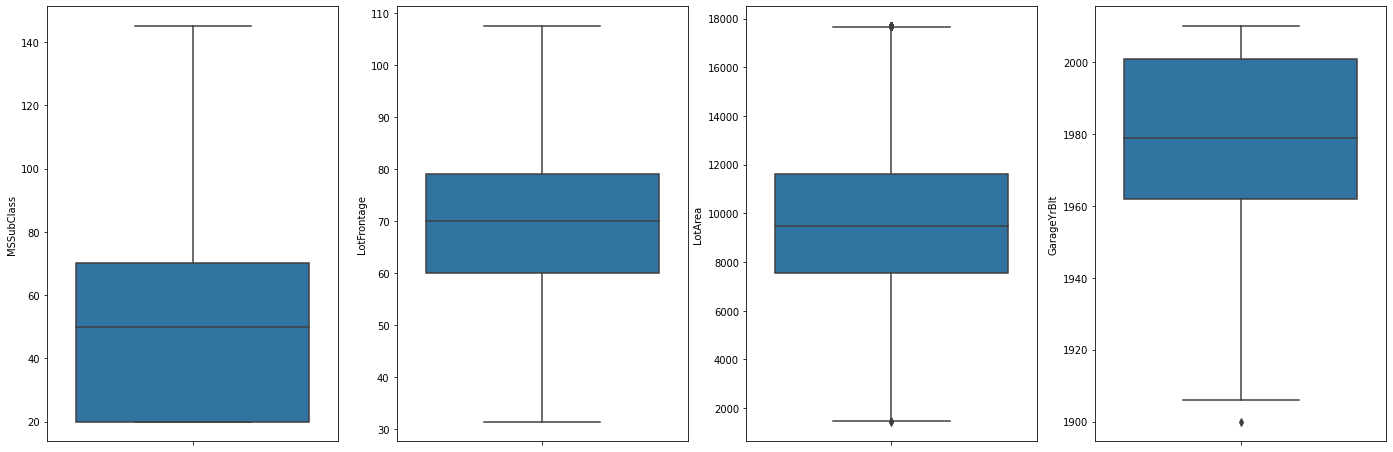

In [117]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(141)
sns.boxplot(y="MSSubClass",data=df_pd3)
plt.subplot(142)
sns.boxplot(y="LotFrontage",data=df_pd3)
plt.subplot(143)
sns.boxplot(y="LotArea",data=df_pd3)
plt.subplot(144)
sns.boxplot(y="GarageYrBlt",data=df_pd2)
plt.show()

### Handling outlier in Test Data

In [118]:
pd_9=test_data.toPandas()

In [119]:
pd_9.describe()

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.645648,9819.161069,1971.357779,1983.662783,100.712132,439.203564,52.619602,554.294722,1046.117889,1156.534613,325.967786,3.543523,1486.045922,0.433859,0.065113,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.736121,1.766278,472.769020,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,20.561791,4955.517327,30.390071,21.130467,176.709827,455.111888,176.693301,437.110508,442.746712,398.165820,420.610226,44.043251,485.566099,0.530527,0.252307,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,25.714527,0.775703,216.974165,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,60.000000,7391.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.500000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1960.500000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,69.000000,9399.000000,1973.000000,1992.000000,0.000000,351.000000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1978.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,78.000000,11517.500000,2001.000000,2004.000000,162.000000,752.000000,0.000000,797.500000,1304.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2001.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [120]:
#create quantile dataframe
def quantile(e):
    percentiles = [0.25, 0.5, 0.75]
    quant=spark.createDataFrame(zip(percentiles, *e.approxQuantile(num_cols_test, percentiles, 0.0)),
                               ['percentile']+num_cols_test) #calculate quantile from pyspark dataframe, 0.0 is relativeError,
                                                        #The relative target precision to achieve (>= 0). If set to zero, 
                                                        #the exact quantiles are computed, which could be very expensive
                                                        #and aggregate the result with percentiles variable, 
                                                        #then create pyspark dataframe
    return quant
    

In [121]:
#call funtion quantile
quantile=quantile(test_data)

In [122]:
quantile.select('MSSubClass').show()

+----------+
|MSSubClass|
+----------+
|      20.0|
|      50.0|
|      70.0|
+----------+



In [123]:
#call function to calculate lower side and replace value under lower side with value lower side
for i in num_cols_test:
    lower=lower_value(quantile,i)
    test_data=replce_outlier_low2(test_data, i, lower)

#call function to calculate upper side and replace value above upper side with value upper side
for x in num_cols_test:
    upper=upper_value(quantile,x)
    test_data=replce_outlier_up2(test_data, x, upper)


In [124]:
test_data.count()

1459

### Checking Outlier after removing outlier

In [125]:
pd_3=test_data.toPandas()


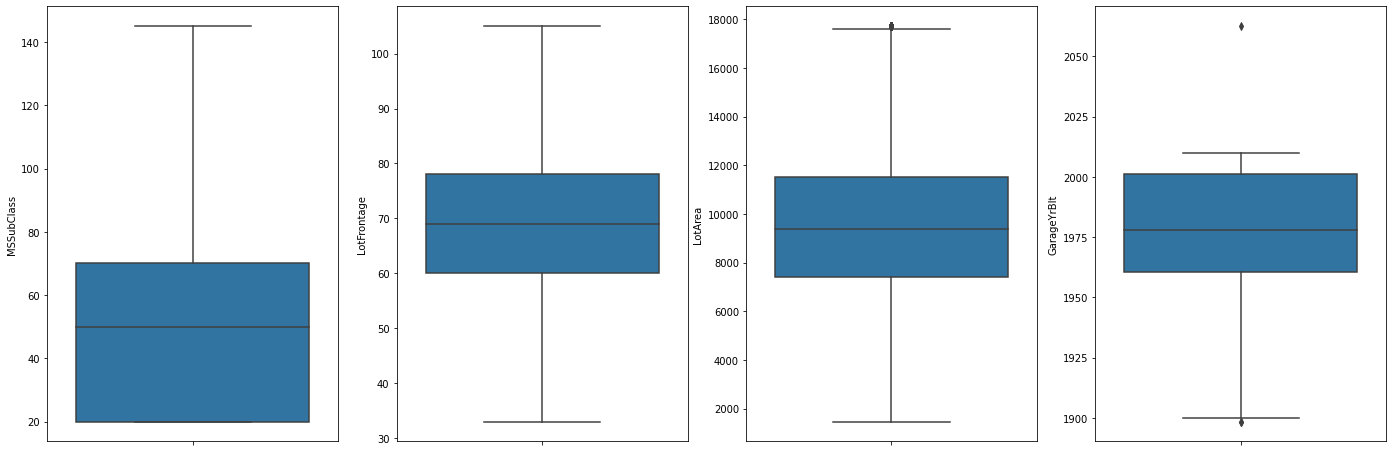

In [126]:
#Check outlier in numerical variable
plt.figure(figsize=(24,8))
plt.subplot(141)
sns.boxplot(y="MSSubClass",data=pd_3)
plt.subplot(142)
sns.boxplot(y="LotFrontage",data=pd_3)
plt.subplot(143)
sns.boxplot(y="LotArea",data=pd_3)
plt.subplot(144)
sns.boxplot(y="GarageYrBlt",data=pd_3)
plt.show()


### Feature Engineering

In [128]:
def check_distinct(a1,a2):
    """input are two dataframe that you want to compare categorical variables and the output is 
    total distinct categories in both dataframe"""
    total1=0
    total2=0
    for y in cat_cols:
        distinct1=a1.select([y]).distinct().count() #count distinct column in dataframe1
        distinct2=a2.select([y]).distinct().count() #count distinct column in dataframe2
        var1=a1.select([y]).distinct().collect() #define distinct category in column in dataframe1
        var1=[r[y] for r in var1]
        var2=a2.select([y]).distinct().collect()
        var2=[r[y] for r in var2]
        total1=total1+distinct1
        total2=total2+distinct2   
    return total1, total2
    

In [129]:
#function to execute feature engineering
def feature_engineering(a1):
    """Function for feature engineering (StringIndexer and OneHotEncoder process)"""
    cat_columns_string_vec = []
    for c in cat_cols:
        cat_columns_string= c+"_vec"
        cat_columns_string_vec.append(cat_columns_string)
    stringIndexer = [StringIndexer(inputCol=x, outputCol=x+"_Index")
                  for x in cat_cols]
    #use oneHotEncoder to convert categorical variable to binary
    encoder = [OneHotEncoder(inputCol=x+"_Index", outputCol=y)
           for x,y in zip(cat_cols, cat_columns_string_vec)]
    #create list of stringIndexer and encoder with 2 dimension
    tmp = [[i,j] for i,j in zip(stringIndexer, encoder)]
    tmp = [i for sublist in tmp for i in sublist]
    cols_assember=num_id + num_cols + cat_columns_string_vec
    assembler=VectorAssembler(inputCols=cols_assember, outputCol='features')
    tmp += [assembler]
    pipeline=Pipeline(stages=tmp)
    df_final_feat=pipeline.fit(a1).transform(a1)
    return df_final_feat
    

In [130]:
#fucntion to call fucntion feature_engineering and check_distinct
def Main_feature_engineering(df,df2):   
    """Function for calling check_distinct and feature_engineering. Then Join data train and data test if distinct categories 
    between data train and data test not same then do feature engineering, If distinct same will do feature engineering data train
    and data test separately"""
    dist_total1, dist_total2=check_distinct(df,df2)   
    if dist_total1!=dist_total2:
        Label_df=df.select('Id', 'label')
        df_final2=df.drop('label')
        all_df =df_final2.union(df2)
        all_df_feat=feature_engineering(all_df)
        id_train=df.select('Id').collect()
        id_train=[r['Id'] for r in id_train]
        id_test=df2.select('Id').collect()
        id_test=[r['Id'] for r in id_test]
        a=all_df_feat.filter(all_df['Id'].isin(id_train))
        b=all_df_feat.filter(all_df['Id'].isin(id_test))
        a=a.join(Label_df, 'Id')
    else:
        a=feature_engineering(df)
        b=feature_engineering(df2)        
    return a,b
    

In [131]:
#call function feature engineering
%time data2, test2=Main_feature_engineering(df_final, test_data)

CPU times: user 2.68 s, sys: 629 ms, total: 3.31 s
Wall time: 3min 35s


#### Train Data

In [132]:
#view result of feature engineering in data train
data2.select('Id', 'features').show(5)

+---+--------------------+
| Id|            features|
+---+--------------------+
|  1|(222,[0,1,2,3,4,5...|
|  2|(222,[0,1,2,3,4,5...|
|  3|(222,[0,1,2,3,4,5...|
|  4|(222,[0,1,2,3,4,5...|
|  5|(222,[0,1,2,3,4,5...|
+---+--------------------+
only showing top 5 rows



#### Test Data

In [133]:
#view result of feature engineering in data test
test2.select('Id', 'features').show(5)

+----+--------------------+
|  Id|            features|
+----+--------------------+
|1461|(222,[0,1,2,3,4,5...|
|1462|(222,[0,1,2,3,4,5...|
|1463|(222,[0,1,2,3,4,5...|
|1464|(222,[0,1,2,3,4,5...|
|1465|(222,[0,1,2,3,4,5...|
+----+--------------------+
only showing top 5 rows



### Split Data train into train and test

In [135]:
data_train, data_test=data2.randomSplit([0.7,0.3], 24)


### Modeling and Evaluation

##### Modelling

We will use four algorithm to make a model and prediction, they are:

    1. Linear Regression Linear regression used logit function in prediction the probability.
    2. Decision Tree This algorithm will find the most significant independent variable to create a values.
    3. Random Forest This algorithm build multiple decision trees and merges them together and use bagging method.
    4. Gradient Boosting This algorithm use boosting ensemble technic. This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors.



##### Evaluation

To evaluate model we use metrics, below:

    1. RMSE (Root Mean Square Error) RMSE measures the differences between predicted values by the model and the actual values. RMSE can also state the size of the error generated by a prediction model.

    2. R2 or R squared R-squared is a statistical measure of how close the data are to the fitted regression line. R-squared is always between 0 and 100%:
        i) 0% indicates that the model explains none of the variability of the response data around its mean.
        ii) 100% indicates that the model explains all the variability of the response data around its mean.



### Modelling & Evaluation in Data train

##### Linear Regression

In [136]:
#Create logistic regression model to data train
lr = LinearRegression(featuresCol='features', labelCol='label')

#fit model to data train
lr_model = lr.fit(data_train)

In [137]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

Coefficients: [-0.8012313584350264,-71.54420599270868,-14.059051138933986,1.1721008763186718,413.0044602216182,139.669700065111,7.533862670193856,26.41482763758888,0.0,4.472536739498359,14.101713040556564,92.40546924529231,94.67300643849501,0.0,-44.23362244765757,1415.7701804014423,0.0,5018.162724021271,2509.1907582073263,-2166.917107952735,0.0,1518.7636618643828,7195.469869141271,-16.397671924780724,6846.7902293360185,3.6134961349882087,13.063847564341998,25.982390153840463,0.0,0.0,0.0,0.0,0.0,-508.7200950468485,-31.822582243121754,-1148.592105018686,-1930.0023879441835,14625.043441028272,28146.392608354097,-877.5347556135988,616.175617097255,-1532.2261366752314,-1388.6605068351416,14056.32268340312,12611.748704153122,17794.030121325195,16927.83907077295,5789.192477683284,10077.92597736486,13493.921197352716,-17385.266426172024,-10853.754112455103,1019.3445762372181,-201.47723183369536,4560.931817045412,-2810.8420491110946,-119.90075656926138,19611.674704879377,4239.209344250719,8535.

In [138]:
#Summarize model over the data train and see the residual
trainingSummary = lr_model.summary
trainingSummary.residuals.show()

+-------------------+
|          residuals|
+-------------------+
|  2818.850749162608|
|-14699.945181316813|
|  18507.76257389167|
| -19515.49064049602|
| -44556.95399836532|
|  -33075.2422584201|
|  28195.33762543404|
|  9039.228381743073|
|-14615.239498393727|
| -53716.48689244536|
|  9680.310531041934|
| -7461.119670161628|
|-15114.948668611352|
|-17679.148379449034|
| -4223.813984580687|
|-11397.981837583124|
| -5963.766458516126|
|-2389.7743819596944|
|  525.9074781677919|
|  4614.923965892172|
+-------------------+
only showing top 20 rows



In [139]:
#calculate RMSE and R2 in training data
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 19340.489034
r2: 0.943460


In [140]:
#Transform model to data test
lr_prediction= lr_model.transform(data_test)

In [141]:
#view id, label, prediction and probability from result of modelling
lr_prediction.select("prediction","label","features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|238480.60088580393|200000|(222,[0,1,2,3,4,5...|
|122486.09025905875|118000|(222,[0,1,2,3,4,5...|
|225841.87241910223|279500|(222,[0,1,2,3,4,5...|
|155405.68697358936|157000|(222,[0,1,2,3,4,5...|
| 148113.3813701911|159000|(222,[0,1,2,3,4,5...|
+------------------+------+--------------------+
only showing top 5 rows



##### Linear Regression Evaluation

In [142]:
#Calculate R squared
lr_evaluator=RegressionEvaluator(predictionCol='prediction', metricName='r2')
print("R squared (R2) on test data=%g" % lr_evaluator.evaluate(lr_prediction))

R squared (R2) on test data=0.843367


In [143]:
#Calculate RMSE
lr_evaluator=RegressionEvaluator(predictionCol='prediction', metricName='rmse')
print("Root Mean Squared Error (RMSE) on linear regression model=%g" % lr_evaluator.evaluate(lr_prediction))

Root Mean Squared Error (RMSE) on linear regression model=29559.2


In [144]:
#another way to calculate RMSE, and result is same with syntax above
test_result=lr_model.evaluate(data_test)
print("Root Mean Squared Error (RMSE) on linear regression model=%g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on linear regression model=29559.2


In [145]:
test_result.residuals.show(6)

+------------------+
|         residuals|
+------------------+
|-38480.60088580393|
| -4486.09025905875|
|53658.127580897766|
| 1594.313026410644|
|10886.618629808887|
|20701.474765086314|
+------------------+
only showing top 6 rows



### Linear Regression With Hyper-Parameter Tuning

In [146]:
#Create linear regression model to data train
lr_hyper = LinearRegression(featuresCol='features', labelCol='label')


#Hyper-Parameter Tuning
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_hyper.regParam, [0.1, 0.01]) \
    .addGrid(lr_hyper.elasticNetParam, [0.8, 0.7]) \
    .build()
crossval_lr = CrossValidator(estimator=lr_hyper,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=RegressionEvaluator(),
                             numFolds=3)
#fit model to data train
lr_model_hyper= crossval_lr.fit(data_train)


In [147]:
#Summarize model over the data train and see the residual
trainingSummary = lr_model_hyper.bestModel.summary
trainingSummary.residuals.show(5)

+-------------------+
|          residuals|
+-------------------+
| 3660.7639485338004|
|-16853.421688191243|
| 17920.982363340678|
|-22259.377297905274|
| -43451.05497246527|
+-------------------+
only showing top 5 rows



In [148]:
#calculate RMSE and R2 in training data
trainingSummary = lr_model_hyper.bestModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 19768.103571
r2: 0.940933


In [149]:
#Transform model to data test
lr_prediction_hyper= lr_model_hyper.transform(data_test)

In [150]:
#view label, prediction and feature from result of modelling
lr_prediction_hyper.select("prediction","label","features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|243202.78342493286|200000|(222,[0,1,2,3,4,5...|
|112656.46003471478|118000|(222,[0,1,2,3,4,5...|
|225473.75558152702|279500|(222,[0,1,2,3,4,5...|
|151952.90199248272|157000|(222,[0,1,2,3,4,5...|
|151084.05604206596|159000|(222,[0,1,2,3,4,5...|
+------------------+------+--------------------+
only showing top 5 rows



### Linear Regression With Hyper-Parameter Tuning Evaluation

In [151]:
#Calculate RMSE
eval_rmse=RegressionEvaluator(metricName="rmse")
print("Root Mean Squared Error (RMSE) on linear regression model=%g" % eval_rmse.evaluate(lr_prediction_hyper))


Root Mean Squared Error (RMSE) on linear regression model=29012.7


In [152]:
#Calculate Rsquared
eval_r2=RegressionEvaluator(metricName="r2")
print("R squared (R2) on linear regression model=%g" % eval_r2.evaluate(lr_prediction_hyper))


R squared (R2) on linear regression model=0.849105


### Decision Tree Regression

In [153]:
#Create Decision Tree model regression
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')

#Fit model to data train
dt_model = dt.fit(data_train)

#Make prediction on data test
dt_prediction = dt_model.transform(data_test)


In [154]:
#View result with column selection
dt_prediction.select("prediction","label","features").show(5)


+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|162840.51515151514|200000|(222,[0,1,2,3,4,5...|
|128544.82653061225|118000|(222,[0,1,2,3,4,5...|
| 192090.2582781457|279500|(222,[0,1,2,3,4,5...|
| 149494.2105263158|157000|(222,[0,1,2,3,4,5...|
|149833.33333333334|159000|(222,[0,1,2,3,4,5...|
+------------------+------+--------------------+
only showing top 5 rows



### Decision Tree Regression Evaluation

In [155]:
#Calculate R squared
dt_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='r2')
print("R squared (R2) on Decision Tree Model=%g" % dt_evaluator.evaluate(dt_prediction))


R squared (R2) on Decision Tree Model=0.668101


In [156]:
#Calculate RMSE
dt_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='rmse')
print("Root Mean Squared Error (RMSE) on Decision Tree Model=%g" % dt_evaluator.evaluate(dt_prediction))


Root Mean Squared Error (RMSE) on Decision Tree Model=43028.3


### Decision Tree Regression with Hyper-Parameter Tuning

In [157]:
#Create Decision Tree Model
dt_hyper=DecisionTreeRegressor(featuresCol = 'features', labelCol = 'label')

#Hyper-Parameter Tuning
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt_hyper.maxDepth, [5, 7]) \
    .addGrid(dt_hyper.maxBins, [10,20]) \
    .build()
crossval_dt = CrossValidator(estimator=dt_hyper,
                             estimatorParamMaps=paramGrid_dt,
                             evaluator=RegressionEvaluator(),
                             numFolds=5)
#fit model to data train
dt_model_hyper = crossval_dt.fit(data_train)


In [158]:
#Transform model to data test
dt_prediction_hyper= dt_model_hyper.transform(data_test)

In [159]:
#View prediction, label and featues from prediction
dt_prediction_hyper.select("prediction","label","features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|170757.44827586206|200000|(222,[0,1,2,3,4,5...|
|          100000.0|118000|(222,[0,1,2,3,4,5...|
|200541.34210526315|279500|(222,[0,1,2,3,4,5...|
| 143263.0792079208|157000|(222,[0,1,2,3,4,5...|
|160749.10714285713|159000|(222,[0,1,2,3,4,5...|
+------------------+------+--------------------+
only showing top 5 rows



### Decision Tree Regression with Hyper-Parameter Tuning Evaluation

In [160]:
#Calculate Rsquared
eval_r2=RegressionEvaluator(metricName="r2")
print("R squared (R2) on Decision Tree Model=%g" % eval_r2.evaluate(dt_prediction_hyper))


R squared (R2) on Decision Tree Model=0.629514


In [161]:
#Calculate RMSE
eval_rmse=RegressionEvaluator(metricName="rmse")
print("Root Mean Squared Error (RMSE) on Decision Tree Model=%g" % eval_rmse.evaluate(dt_prediction_hyper))


Root Mean Squared Error (RMSE) on Decision Tree Model=45460.8


### Random Forest Regression

In [163]:
#Create Random forest model regression
rf = RandomForestRegressor(featuresCol ='features', labelCol = 'label')

#Fit model to data train
rf_model = rf.fit(data_train)

#Make prediction on data test
rf_prediction = rf_model.transform(data_test)


In [164]:
#View result with column selection
rf_prediction.select("prediction","label","features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|193287.27684986667|200000|(222,[0,1,2,3,4,5...|
|126407.55993930859|118000|(222,[0,1,2,3,4,5...|
|244982.92380911703|279500|(222,[0,1,2,3,4,5...|
|142694.14423357637|157000|(222,[0,1,2,3,4,5...|
|157719.23713357688|159000|(222,[0,1,2,3,4,5...|
+------------------+------+--------------------+
only showing top 5 rows



### Random Forest Regression Evaluation

In [165]:
#Calculate R squared
rf_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='r2')
print("R squared (R2) on Random Forest Model=%g" % rf_evaluator.evaluate(rf_prediction))


R squared (R2) on Random Forest Model=0.823071


In [166]:
#Calculate RMSE
rf_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='rmse')
print("Root Mean Squared Error (RMSE) on Random Forest Model=%g" % rf_evaluator.evaluate(rf_prediction))


Root Mean Squared Error (RMSE) on Random Forest Model=31415.9


### Random Forest Regression with Hyper Parameter Tuning

In [167]:
#define random forest regressor
rf_hyper= RandomForestRegressor(featuresCol='features', labelCol="label")

# Hyper-Parameter Tuning
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf_hyper.numTrees, [40, 60, 80, 100]) \
    .build()
crossval_rf = CrossValidator(estimator=rf_hyper,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=RegressionEvaluator(),
                             numFolds=3) 
#fit model to data train
rf_model_hyper=crossval_rf.fit(data_train)


In [168]:
#Transform model to data test
rf_prediction_hyper= rf_model_hyper.transform(data_test)


In [169]:
#View result of prediction, label, features
rf_prediction_hyper.select("prediction","label","features").show(5)


+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|183414.60641478345|200000|(222,[0,1,2,3,4,5...|
|128471.65255791164|118000|(222,[0,1,2,3,4,5...|
| 234994.4373156369|279500|(222,[0,1,2,3,4,5...|
|148499.88983849037|157000|(222,[0,1,2,3,4,5...|
|158820.89719652123|159000|(222,[0,1,2,3,4,5...|
+------------------+------+--------------------+
only showing top 5 rows



### Random Forest Regression with Hyper Parameter Tuning Evaluation

In [170]:
#Calculate R squared
rf_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='r2')
print("R squared (R2) on Random Forest Model=%g" % rf_evaluator.evaluate(rf_prediction_hyper))

R squared (R2) on Random Forest Model=0.833808


In [171]:
#Calculate RMSE
rf_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='rmse')
print("Root Mean Squared Error (RMSE) on Random Forest Model=%g" % rf_evaluator.evaluate(rf_prediction_hyper))

Root Mean Squared Error (RMSE) on Random Forest Model=30447.8


### Gradient Boosted Tree Regression

In [172]:
#Create Gradient Boosted Tree regression
gbt = GBTRegressor(featuresCol ='features', labelCol = 'label', maxIter=15)

#Fit model to data train
gbt_model = gbt.fit(data_train)

#Make prediction on data test
gbt_prediction = gbt_model.transform(data_test)


In [173]:
#View result of prediction, label, features
gbt_prediction.select("prediction","label","features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|161738.78075229374|200000|(222,[0,1,2,3,4,5...|
|121344.67170597758|118000|(222,[0,1,2,3,4,5...|
| 202572.5120902472|279500|(222,[0,1,2,3,4,5...|
|148075.08001254936|157000|(222,[0,1,2,3,4,5...|
|158074.00160390075|159000|(222,[0,1,2,3,4,5...|
+------------------+------+--------------------+
only showing top 5 rows



### Gradient Boosted Tree Regression Evaluation

In [174]:
#Calculate R squared
gbt_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='r2')
print("R squared (R2) on Gradient Boosted Model=%g" % gbt_evaluator.evaluate(gbt_prediction))


R squared (R2) on Gradient Boosted Model=0.725535


In [175]:
#Calculate RMSE
gbt_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='rmse')
print("Root Mean Squared Error (RMSE) on Gradient Boosted Model=%g" % gbt_evaluator.evaluate(gbt_prediction))


Root Mean Squared Error (RMSE) on Gradient Boosted Model=39128.6


### Gradient Boosted Tree Regression with Hyper Parameter Tuning

In [176]:
#Create Gradient Boosted Tree regression
gbt_hyper = GBTRegressor(featuresCol ='features', labelCol = 'label')

# Hyper-Parameter Tuning
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt_hyper.maxIter, [10,20])\
    .addGrid(gbt_hyper.maxDepth, [10, 12,15]) \
    .build()
crossval_gbt = CrossValidator(estimator=gbt_hyper,
                             estimatorParamMaps=paramGrid_gbt,
                             evaluator=RegressionEvaluator(),
                             numFolds=3)
#Fit Model to data train
gbt_model_hyper = crossval_gbt.fit(data_train)


In [177]:
#Transform model to data test
gbt_prediction_hyper= gbt_model_hyper.transform(data_test)

In [178]:
#View result of prediction, label, features
gbt_prediction_hyper.select("prediction","label","features").show(5)

+------------------+------+--------------------+
|        prediction| label|            features|
+------------------+------+--------------------+
|172810.51058890997|200000|(222,[0,1,2,3,4,5...|
|127208.00374599783|118000|(222,[0,1,2,3,4,5...|
| 204420.5350769965|279500|(222,[0,1,2,3,4,5...|
|154431.48519001412|157000|(222,[0,1,2,3,4,5...|
|150139.05600016238|159000|(222,[0,1,2,3,4,5...|
+------------------+------+--------------------+
only showing top 5 rows



### Gradient Boosted Tree Regression with Hyper Parameter Tuning Evaluation

In [179]:
#Calculate R squared
gbt_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='r2')
print("R squared (R2) on Gradient Boosted Model=%g" % gbt_evaluator.evaluate(gbt_prediction_hyper))


R squared (R2) on Gradient Boosted Model=0.665681


In [180]:
#Calculate RMSE
gbt_evaluator=RegressionEvaluator(predictionCol='prediction', labelCol="label", metricName='rmse')
print("Root Mean Squared Error (RMSE) on Gradient Boosted Model=%g" % gbt_evaluator.evaluate(gbt_prediction_hyper))


Root Mean Squared Error (RMSE) on Gradient Boosted Model=43184.9


### Modeling with Test Data

In [181]:
#Transform model to data test
predic= rf_model_hyper.transform(test2)

In [182]:
#View result of prediction, label, features
predic.select("Id", "prediction","features").show(5)

+----+------------------+--------------------+
|  Id|        prediction|            features|
+----+------------------+--------------------+
|1461|126627.86542342977|(222,[0,1,2,3,4,5...|
|1462|149580.86845584496|(222,[0,1,2,3,4,5...|
|1463|183269.79973667063|(222,[0,1,2,3,4,5...|
|1464|185078.57195843893|(222,[0,1,2,3,4,5...|
|1465| 198509.3243903554|(222,[0,1,2,3,4,5...|
+----+------------------+--------------------+
only showing top 5 rows



In [183]:
#select Id and prediction column
my_submission=predic.select("Id","prediction")

In [184]:
#convert to Pandas dataframe
my_submission2=my_submission.toPandas()

In [186]:
#save to csv
my_submission2.to_csv('my_submission4.csv', index = False, header = True)